In [1]:
#BFMDRS & Clinical Data Analysis - Correlation to LFP metrics
#Arjun Balachandar Aug 2024
#This script is used to analyze the clinical data from the SD patients, comparing SD vs non-SD LFP metrics vs clinical data using GLMs
#Of note, non-SD is often referred to as oneYear, although patients non-SD recordings could be at anytime in the non-SD period

#Directories and File Names
PATH = '/Users/arjunbalachandar/Desktop/University of Toronto/Research/Ibrahim Lab/Dystonia Project/'
lfpDir = PATH + 'data_processed/'
clinVarFile = PATH + 'statusDystonicusDates_NEW.csv'
implantDateFile = PATH + 'patientSummary.csv'
optimalChannelsFile = PATH + 'AvailabilitySummary - with optimal channels - deidentified.xlsx' # Determined in consultation with Dr George Ibrahim
resultsDir = PATH + 'Analysis/'
resultsLFPPowersDir = resultsDir + 'LFP Powers/'
resultsPSDsDir = resultsDir + 'PSDs/'
resultsPSDPeaksDir = resultsDir + 'PSDPeaks/'
resultsFilename = 'powerChangesAfterCuringStatusDystonicus.csv'
resultsPSDFilename = 'PSDsAfterCuringStatusDystonicus.csv'
resultsCohDir = resultsDir + 'Coherence/'
resultsCohFilename = 'coherenceAfterCuringStatusDystonicus.csv'
resultsCohPredetFilename = 'coherencePREDETERAfterCuringStatusDystonicus.csv'
demographicsDir = PATH + 'Demographics/'
demographicsFile = demographicsDir + 'MulticentrePediatric-Demographics and clinical data (raw)_ArjunEdit.csv'
moredemographicsDir = PATH + 'Demographics/Additional Metrics/' #additional clinical metrics
moredemographicsFile_baseline = moredemographicsDir + 'MulticentrePediatric-BaselineDystonia.csv'
moredemographicsFile_6m = moredemographicsDir + 'MulticentrePediatric-6mDystonia.csv'
moredemographicsFile_1y = moredemographicsDir + 'MulticentrePediatric-1yDystonia.csv'
moredemographicsFile_2y = moredemographicsDir + 'MulticentrePediatric-2yDystonia.csv'
moredemographicsFile_3y = moredemographicsDir + 'MulticentrePediatric-3yDystonia.csv'

#Frequency bands
betaLim = [12.5, 30] # In Hertz, define the beta band
thetaLim = [3, 7] # 3.5-7 as per Mark, Was [4,7] before 31 Jan
deltaLim = [1,3]
alphaLim = [7,12.5]
gammaLim = [30,60]
lowbetaLim = [12.5, 20]
highbetaLim = [20, 30]
lowgammaLim = [30, 40]
highgammaLim = [40, 60]
channelOverride = False # True # Should be false. Set to true if you want to set the channel manually (not recommended).
z_score_norm = False #Normalize the LFP values by z-scoring normalization if True
normalize_PSD = True #Normalize the PSD values by dividing by sum of total power of PSD
normalize_clinical_columns = False
normalize_LFP_columns = True

# Initializations
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import signal
from scipy.signal import welch
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore
import re #regular expression
import neurodsp
from neurodsp.utils.norm import normalize_sig
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
import itertools
import seaborn as sns
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import statsmodels.formula.api as smf
import scikit_posthocs as sp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor

diff = lambda x, y: y - x

# Load and process the dates
clinVars_df = pd.read_csv(clinVarFile, delimiter=',')
implantDates_df = pd.read_csv(implantDateFile, delimiter=',')
patList = clinVars_df['Subject ID'].values

plt.rcParams['figure.dpi'] = 600

In [2]:
#Function to get periodic peak powers from pre-extracted values
def extract_peak_powers(psd_df,peak_freqs_df,freq_range):
    freq_range = float(freq_range)
    #Extract the peak powers from the PSD dataframe, FREQ_RANGE = range of freqs around peak to consider
    psd_noID_df = psd_df.drop(['Patient','Implant date','StatusDysStart','Discharge','RecordingStartTime','RecordingType','Channel','IntervalType'], axis=1)
    #only get the columns in the dataframe that have numbers as column names - these are the columns that have frequency values as their names
    freqs = [col for col in psd_noID_df.columns if re.search(r'\d', col)]
    freqs_np = np.array(freqs)

    sum_powers = []

    # Iterate through each row of peak_freqs_df
    for index, psd_row in psd_noID_df.iterrows():
        # Get the corresponding 'Peak CF' value from peak_freqs_df
        peak_freq = float(peak_freqs_df.loc[index, 'Peak CF'])

        # Find all columns in psd_noID_df within +/- 2.5 of the peak frequency
        #relevant_columns = [col for col in psd_noID_df.columns if abs(float(col) - float(peak_freq)) <= 2.5]

        # Calculate the sum of the power values in the relevant columns for the current row
        #power_sum = psd_row[relevant_columns].sum()

        range_freqs = [i for i, x in enumerate(freqs) if float(x) >= (peak_freq - freq_range) and float(x) <= (peak_freq + freq_range)]
        power_sum = sum(psd_row[range_freqs])

        # Append the sum to the list
        sum_powers.append(power_sum)

    # Create a new column in peak_freqs_df to store the sum of powers
    peak_powers_df = pd.DataFrame()
    peak_powers_df['Peak Power'] = sum_powers

    return(peak_powers_df)


In [3]:
#Load other clinical metrics
moredemographics_baseline_df = pd.read_csv(moredemographicsFile_baseline, delimiter=',')
moredemographics_6m_df = pd.read_csv(moredemographicsFile_6m, delimiter=',')
moredemographics_1y_df = pd.read_csv(moredemographicsFile_1y, delimiter=',')
moredemographics_2y_df = pd.read_csv(moredemographicsFile_2y, delimiter=',')
moredemographics_3y_df = pd.read_csv(moredemographicsFile_3y, delimiter=',')
#combine moredemographics dataframes into one, but do not duplicate 'record_id' column
moredemographics_6m_df = moredemographics_6m_df.drop(columns=['record_id'])
moredemographics_1y_df = moredemographics_1y_df.drop(columns=['record_id'])
moredemographics_2y_df = moredemographics_2y_df.drop(columns=['record_id'])
moredemographics_3y_df = moredemographics_3y_df.drop(columns=['record_id'])

#combine all moredemographics dataframes into one, combining them horizontally with rows corresponding to the same patient
moredemographics_df = pd.concat([moredemographics_baseline_df,moredemographics_6m_df,moredemographics_1y_df,moredemographics_2y_df,moredemographics_3y_df], axis=1)
#moredemographics_df = pd.concat([moredemographics_baseline_df,moredemographics_6m_df,moredemographics_1y_df,moredemographics_2y_df,moredemographics_3y_df], ignore_index=True)

#Make a new column 'Patient' in moredemographics_df that is the same as record_id, but with 'DBS' added to the beginning followed by 0s to make it 6 characters long
moredemographics_df['Patient'] = 'DBS' + moredemographics_df['record_id'].astype(str).str.zfill(3)

#ADD STATUS DATES FROM CLINVARS TO MOREDEMOGRAPHICS
#Only keep the rows that correspond to patients in patList
moredemographics_df = moredemographics_df[moredemographics_df['Patient'].isin(patList)]
#Add the column 'date_dbs' from clinicalVars to moredemographics_df
moredemographics_df = moredemographics_df.merge(
    clinVars_df[['Subject ID', 'Date of Status dystonicus']].rename(columns={'Date of Status dystonicus': 'date_dbs'}), 
    left_on='Patient', 
    right_on='Subject ID', 
    how='left'
)
# Drop the 'Subject ID' column as it is no longer needed after the merge
moredemographics_df.drop(columns=['Subject ID'], inplace=True)

#Move Patient to the first column
cols = moredemographics_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
moredemographics_df = moredemographics_df[cols]

#drop any columns that do not have the words 'total_score_pedsql', 'promis_p_total' or 'p_qids_total', except keep the 'Patient' column
keywords = ['total_score_pedsql', 'promis_p_total', 'p_qids_total','physical_score_pedsql']
columns_to_keep = [col for col in moredemographics_df.columns if any(keyword in col for keyword in keywords) or col == 'Patient' or col =='date_dbs']
moredemographics_df = moredemographics_df[columns_to_keep]

#---Normalize each of the scores based on max value---
def normalize_columns(df, keyword):
    # Filter columns that contain the keyword
    cols_to_normalize = [col for col in df.columns if keyword in col]
    
    # Find the maximum value across all these columns
    max_value = df[cols_to_normalize].max().max()
    
    # Normalize each of these columns
    df[cols_to_normalize] = df[cols_to_normalize] / max_value


if normalize_clinical_columns:
    for keyword in keywords:
        normalize_columns(moredemographics_df, keyword)
moredemographics_df

prefixes = ['m0', 'm6', 'y1', 'y2', 'y3']
periods = ['status', '6-months', '1-year', '2-years', '3-years']

reshaped_dfs = []
# Loop over each prefix and corresponding period
for prefix, period in zip(prefixes, periods):
    # Select the columns that start with the current prefix
    prefix_cols = [col for col in moredemographics_df.columns if col.startswith(prefix)]
    
    # Remove the prefix from the column names
    df_subset = moredemographics_df[['Patient'] + prefix_cols].copy()
    df_subset.columns = ['Patient'] + [col[len(prefix)+1:] for col in prefix_cols]  # +1 to remove the underscore after the prefix
    
    # Add the 'Period' column with the appropriate value
    df_subset['Period'] = period
    
    # Append the reshaped dataframe to the list
    reshaped_dfs.append(df_subset)

# Concatenate all the reshaped dataframes into a single dataframe
moredemographics_long_df = pd.concat(reshaped_dfs, ignore_index=True)

# Add new column intervalType for binary status/non-status value
moredemographics_long_df['intervalType'] = moredemographics_long_df['Period'].apply(lambda x: 'status' if x == 'status' else 'non-status')

# Display the final reshaped dataframe
moredemographics_long_df

Patient  p_qids_total  physical_score_pedsql  total_score_pedsql  \
0   DBS003           8.0               0.000000           26.086957   
1   DBS005           NaN                    NaN                 NaN   
2   DBS013          12.0              12.500000           48.913043   
3   DBS014          18.0               0.000000           19.565217   
4   DBS018           1.0              55.357143           84.375000   
5   DBS021           NaN              75.000000           57.600000   
6   DBS036          12.0               0.000000           36.956522   
7   DBS039          13.0               3.125000            8.695652   
8   DBS047          20.0               6.250000           23.809524   
9   DBS050          16.0               9.375000           44.565217   
10  DBS003           8.0              84.375000           60.526316   
11  DBS005           8.0              12.500000           36.956522   
12  DBS013          15.0                    NaN                 NaN   
13  DBS014           NaN                    NaN                 NaN   
14  DBS018          15.0              78.125000           55.434783   
15  DBS021           7.0              56.250000           65.217391   
16  DBS036           NaN                    NaN                 NaN   
17  DBS039           9.0              87.500000           64.130435   
18  DBS047          10.0               6.250000           25.000000   
19  DBS050           NaN                    NaN                 NaN   
20  DBS003          11.0              90.625000           91.666667   
21  DBS005           4.0                    NaN                 NaN   
22  DBS013           3.0               0.000000            0.000000   
23  DBS014           NaN                    NaN                 NaN   
24  DBS018          10.0              78.125000           54.545455   
25  DBS021           6.0              81.250000           72.727273   
26  DBS036           NaN                    NaN                 NaN   
27  DBS039          15.0               0.000000           36.363636   
28  DBS047           NaN                    NaN                 NaN   
29  DBS050           NaN                    NaN                 NaN   
30  DBS003           NaN              12.500000           42.391304   
31  DBS005           NaN                    NaN                 NaN   
32  DBS013           NaN              66.666667           50.000000   
33  DBS014           NaN                    NaN                 NaN   
34  DBS018           NaN              50.000000           47.826087   
35  DBS021           NaN                    NaN                 NaN   
36  DBS036           NaN                    NaN                 NaN   
37  DBS039           NaN                    NaN                 NaN   
38  DBS047           NaN                    NaN                 NaN   
39  DBS050           NaN                    NaN                 NaN   
40  DBS003           NaN             100.000000           86.904762   
41  DBS005           NaN              15.625000           46.739130   
42  DBS013           NaN                    NaN                 NaN   
43  DBS014           NaN                    NaN                 NaN   
44  DBS018           NaN                    NaN                 NaN   
45  DBS021           NaN                    NaN                 NaN   
46  DBS036           NaN                    NaN                 NaN   
47  DBS039           NaN                    NaN                 NaN   
48  DBS047           NaN                    NaN                 NaN   
49  DBS050           NaN                    NaN                 NaN   

    promis_p_total    Period intervalType  
0             28.0    status       status  
1              NaN    status       status  
2              0.0    status       status  
3             32.0    status       status  
4              NaN    status       status  
5              NaN    status       status  
6             32.0    status       status  
7             31.0    status 

In [4]:
# Load the demographics data
demographics_df = pd.read_csv(demographicsFile, delimiter=',')

#Only keep data belonging to patients from patList
demographics_df = demographics_df[demographics_df['Patient'].isin(patList)]

#Only keep data with column name either Patient or column name containing 'bfmdrs_movement_scale_calculated'
demographics_df = demographics_df.loc[:,demographics_df.columns.str.contains('Patient|date_dbs|bfmdrs_movement_scale_calculated')]

#NORMALIZE BFMDRS FOR EACH PATIENT, SO MAX IS 1
columns_to_normalize = [
    'bfmdrs_movement_scale_calculated',
    'm6_bfmdrs_movement_scale_calculated',
    'y1_bfmdrs_movement_scale_calculated',
    'y2_bfmdrs_movement_scale_calculated',
    'y3_bfmdrs_movement_scale_calculated'
]

#NORMALIZE BFMDRS
# Normalize each row such that the maximum value in each row is 1
scaler = StandardScaler() #RobustScaler() MinMaxScaler()

# Restructuring the dataframe
demographics_long_df = pd.melt(
    demographics_df,
    id_vars=['Patient', 'date_dbs', 'date_dbs_on'],
    value_vars=[
        'bfmdrs_movement_scale_calculated',
        'm6_bfmdrs_movement_scale_calculated',
        'y1_bfmdrs_movement_scale_calculated',
        'y2_bfmdrs_movement_scale_calculated',
        'y3_bfmdrs_movement_scale_calculated'
    ],
    var_name='Measurement',
    value_name='BFMDRS'
)

# Mapping the new period names based on the measurement type
demographics_long_df['Period'] = demographics_long_df['Measurement'].map({
    'bfmdrs_movement_scale_calculated': 'status',
    'm6_bfmdrs_movement_scale_calculated': '6-months',
    'y1_bfmdrs_movement_scale_calculated': '1-year',
    'y2_bfmdrs_movement_scale_calculated': '2-years',
    'y3_bfmdrs_movement_scale_calculated': '3-years'
})

# Drop the original 'Measurement' column as it's no longer needed
demographics_long_df.drop(columns=['Measurement'], inplace=True)

# Normalize BFMDRS within each patient group
demographics_long_df['BFMDRS_normalized'] = demographics_long_df.groupby('Patient')['BFMDRS'].transform(lambda x: x / x.max())

#Add column with binary BFMDRS (1 or 0) based on threshold of 0.834
demographics_long_df['BFMDRS_MCID'] = np.where(
    demographics_long_df['BFMDRS_normalized'].isna(), 
    np.nan,  # Assign NaN if BFMDRS is NaN
    np.where(demographics_long_df['BFMDRS_normalized'] > 0.834, 1, 0)  # Assign 1 or 0 based on the condition
)

demographics_long_df

Patient    date_dbs date_dbs_on  BFMDRS    Period  BFMDRS_normalized  \
0   DBS003  2021-01-12  2021-01-13    97.0    status           0.932692   
1   DBS005  2021-04-23         NaN   108.5    status           1.000000   
2   DBS013  2021-08-20         NaN    62.5    status           1.000000   
3   DBS014  2021-09-08         NaN    88.0    status           1.000000   
4   DBS018  2022-01-17         NaN    82.5    status           0.959302   
5   DBS021  2022-03-25         NaN    98.0    status           1.000000   
6   DBS036  2023-08-16  2023-09-12    37.0    status           1.000000   
7   DBS047         NaN         NaN     NaN    status                NaN   
8   DBS050         NaN         NaN     NaN    status                NaN   
9   DBS039         NaN         NaN     NaN    status                NaN   
10  DBS003  2021-01-12  2021-01-13    96.0  6-months           0.923077   
11  DBS005  2021-04-23         NaN    49.5  6-months           0.456221   
12  DBS013  2021-08-20         NaN     NaN  6-months                NaN   
13  DBS014  2021-09-08         NaN     NaN  6-months                NaN   
14  DBS018  2022-01-17         NaN    86.0  6-months           1.000000   
15  DBS021  2022-03-25         NaN     NaN  6-months                NaN   
16  DBS036  2023-08-16  2023-09-12    13.0  6-months           0.351351   
17  DBS047         NaN         NaN     NaN  6-months                NaN   
18  DBS050         NaN         NaN     NaN  6-months                NaN   
19  DBS039         NaN         NaN     NaN  6-months                NaN   
20  DBS003  2021-01-12  2021-01-13   104.0    1-year           1.000000   
21  DBS005  2021-04-23         NaN    32.5    1-year           0.299539   
22  DBS013  2021-08-20         NaN    43.5    1-year           0.696000   
23  DBS014  2021-09-08         NaN     NaN    1-year                NaN   
24  DBS018  2022-01-17         NaN     NaN    1-year                NaN   
25  DBS021  2022-03-25         NaN    58.0    1-year           0.591837   
26  DBS036  2023-08-16  2023-09-12    13.0    1-year           0.351351   
27  DBS047         NaN         NaN     NaN    1-year                NaN   
28  DBS050         NaN         NaN     NaN    1-year                NaN   
29  DBS039         NaN         NaN     NaN    1-year                NaN   
30  DBS003  2021-01-12  2021-01-13    99.0   2-years           0.951923   
31  DBS005  2021-04-23         NaN     NaN   2-years                NaN   
32  DBS013  2021-08-20         NaN     NaN   2-years                NaN   
33  DBS014  2021-09-08         NaN     NaN   2-years                NaN   
34  DBS018  2022-01-17         NaN     NaN   2-years                NaN   
35  DBS021  2022-03-25         NaN     NaN   2-years                NaN   
36  DBS036  2023-08-16  2023-09-12     NaN   2-years                NaN   
37  DBS047         NaN         NaN     NaN   2-years                NaN   
38  DBS050         NaN         NaN     NaN   2-years                NaN   
39  DBS039         NaN         NaN     NaN   2-years                NaN   
40  DBS003  2021-01-12  2021-01-13    49.5   3-years           0.475962   
41  DBS005  2021-04-23         NaN     NaN   3-years                NaN   
42  DBS013  2021-08-20         NaN     NaN   3-years                NaN   
43  DBS014  2021-09-08         NaN     NaN   3-years                NaN   
44  DBS018  2022-01-17         NaN     NaN   3-years                NaN   
45  DBS021  2022-03-25         NaN     NaN   3-years                NaN   
46  DBS036  2023-08-16  2023-09-12     NaN   3-years                NaN   
47  DBS047         NaN         NaN     NaN   3-years                NaN   
48  DBS050         NaN         NaN     NaN   3-years                NaN   
49  DBS039         NaN         NaN     NaN   3-years                NaN   

    BFMDRS_MCID  
0           1.0  
1           1.0  
2           1.0  
3           1.0  
4           1.0  
5           1.0  
6           1.0  
7           NaN  
8           NaN

In [5]:
#BFMDRS STATS ANALYSIS:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Find unique patients with at least one MCID value of 0
patients_with_mcid_0 = demographics_long_df[demographics_long_df['BFMDRS_MCID'] == 0]['Patient'].nunique()
print(f"Number of patients with at least one MCID value of 0: {patients_with_mcid_0}")

# Separate the data into 'status' and 'non-status' periods
status_data = demographics_long_df[demographics_long_df['Period'] == 'status']['BFMDRS_normalized']
non_status_data = demographics_long_df[demographics_long_df['Period'] != 'status']['BFMDRS_normalized']

status_data = status_data.dropna()
non_status_data = non_status_data.dropna()

# Calculate mean and standard deviation for 'status' period
status_mean = status_data.mean()
status_std = status_data.std()

# Calculate mean and standard deviation for 'non-status' period
non_status_mean = non_status_data.mean()
non_status_std = non_status_data.std()

# Print the results
print(f"'Status' Period - Mean: {status_mean}, Standard Deviation: {status_std}")
print(f"'Non-Status' Period - Mean: {non_status_mean}, Standard Deviation: {non_status_std}")

# Check for normality using Shapiro-Wilk test
status_normality = shapiro(status_data.dropna())[1]  # p-value for normality in 'status' period
non_status_normality = shapiro(non_status_data.dropna())[1]  # p-value for normality in non-'status' periods

# Determine if both distributions are normally distributed (p > 0.05)
if status_normality > 0.05 and non_status_normality > 0.05:
    # Perform t-test (parametric test) if data is normally distributed
    t_stat, p_value = ttest_ind(status_data, non_status_data, nan_policy='omit')
    test_used = "T-test"
else:
    # Perform Mann-Whitney U test (non-parametric test) if data is not normally distributed
    u_stat, p_value = mannwhitneyu(status_data, non_status_data, alternative='two-sided')
    test_used = "Mann-Whitney U Test"

print(f"Test Used: {test_used}")
print(f"P-value: {p_value}")
print(f"U-stat: {u_stat}")



Number of patients with at least one MCID value of 0: 5
'Status' Period - Mean: 0.9845706618962433, Standard Deviation: 0.027447449264092084
'Non-Status' Period - Mean: 0.6452055767747011, Standard Deviation: 0.2801819227072028
Test Used: Mann-Whitney U Test
P-value: 0.008951209134622207
U-stat: 67.0


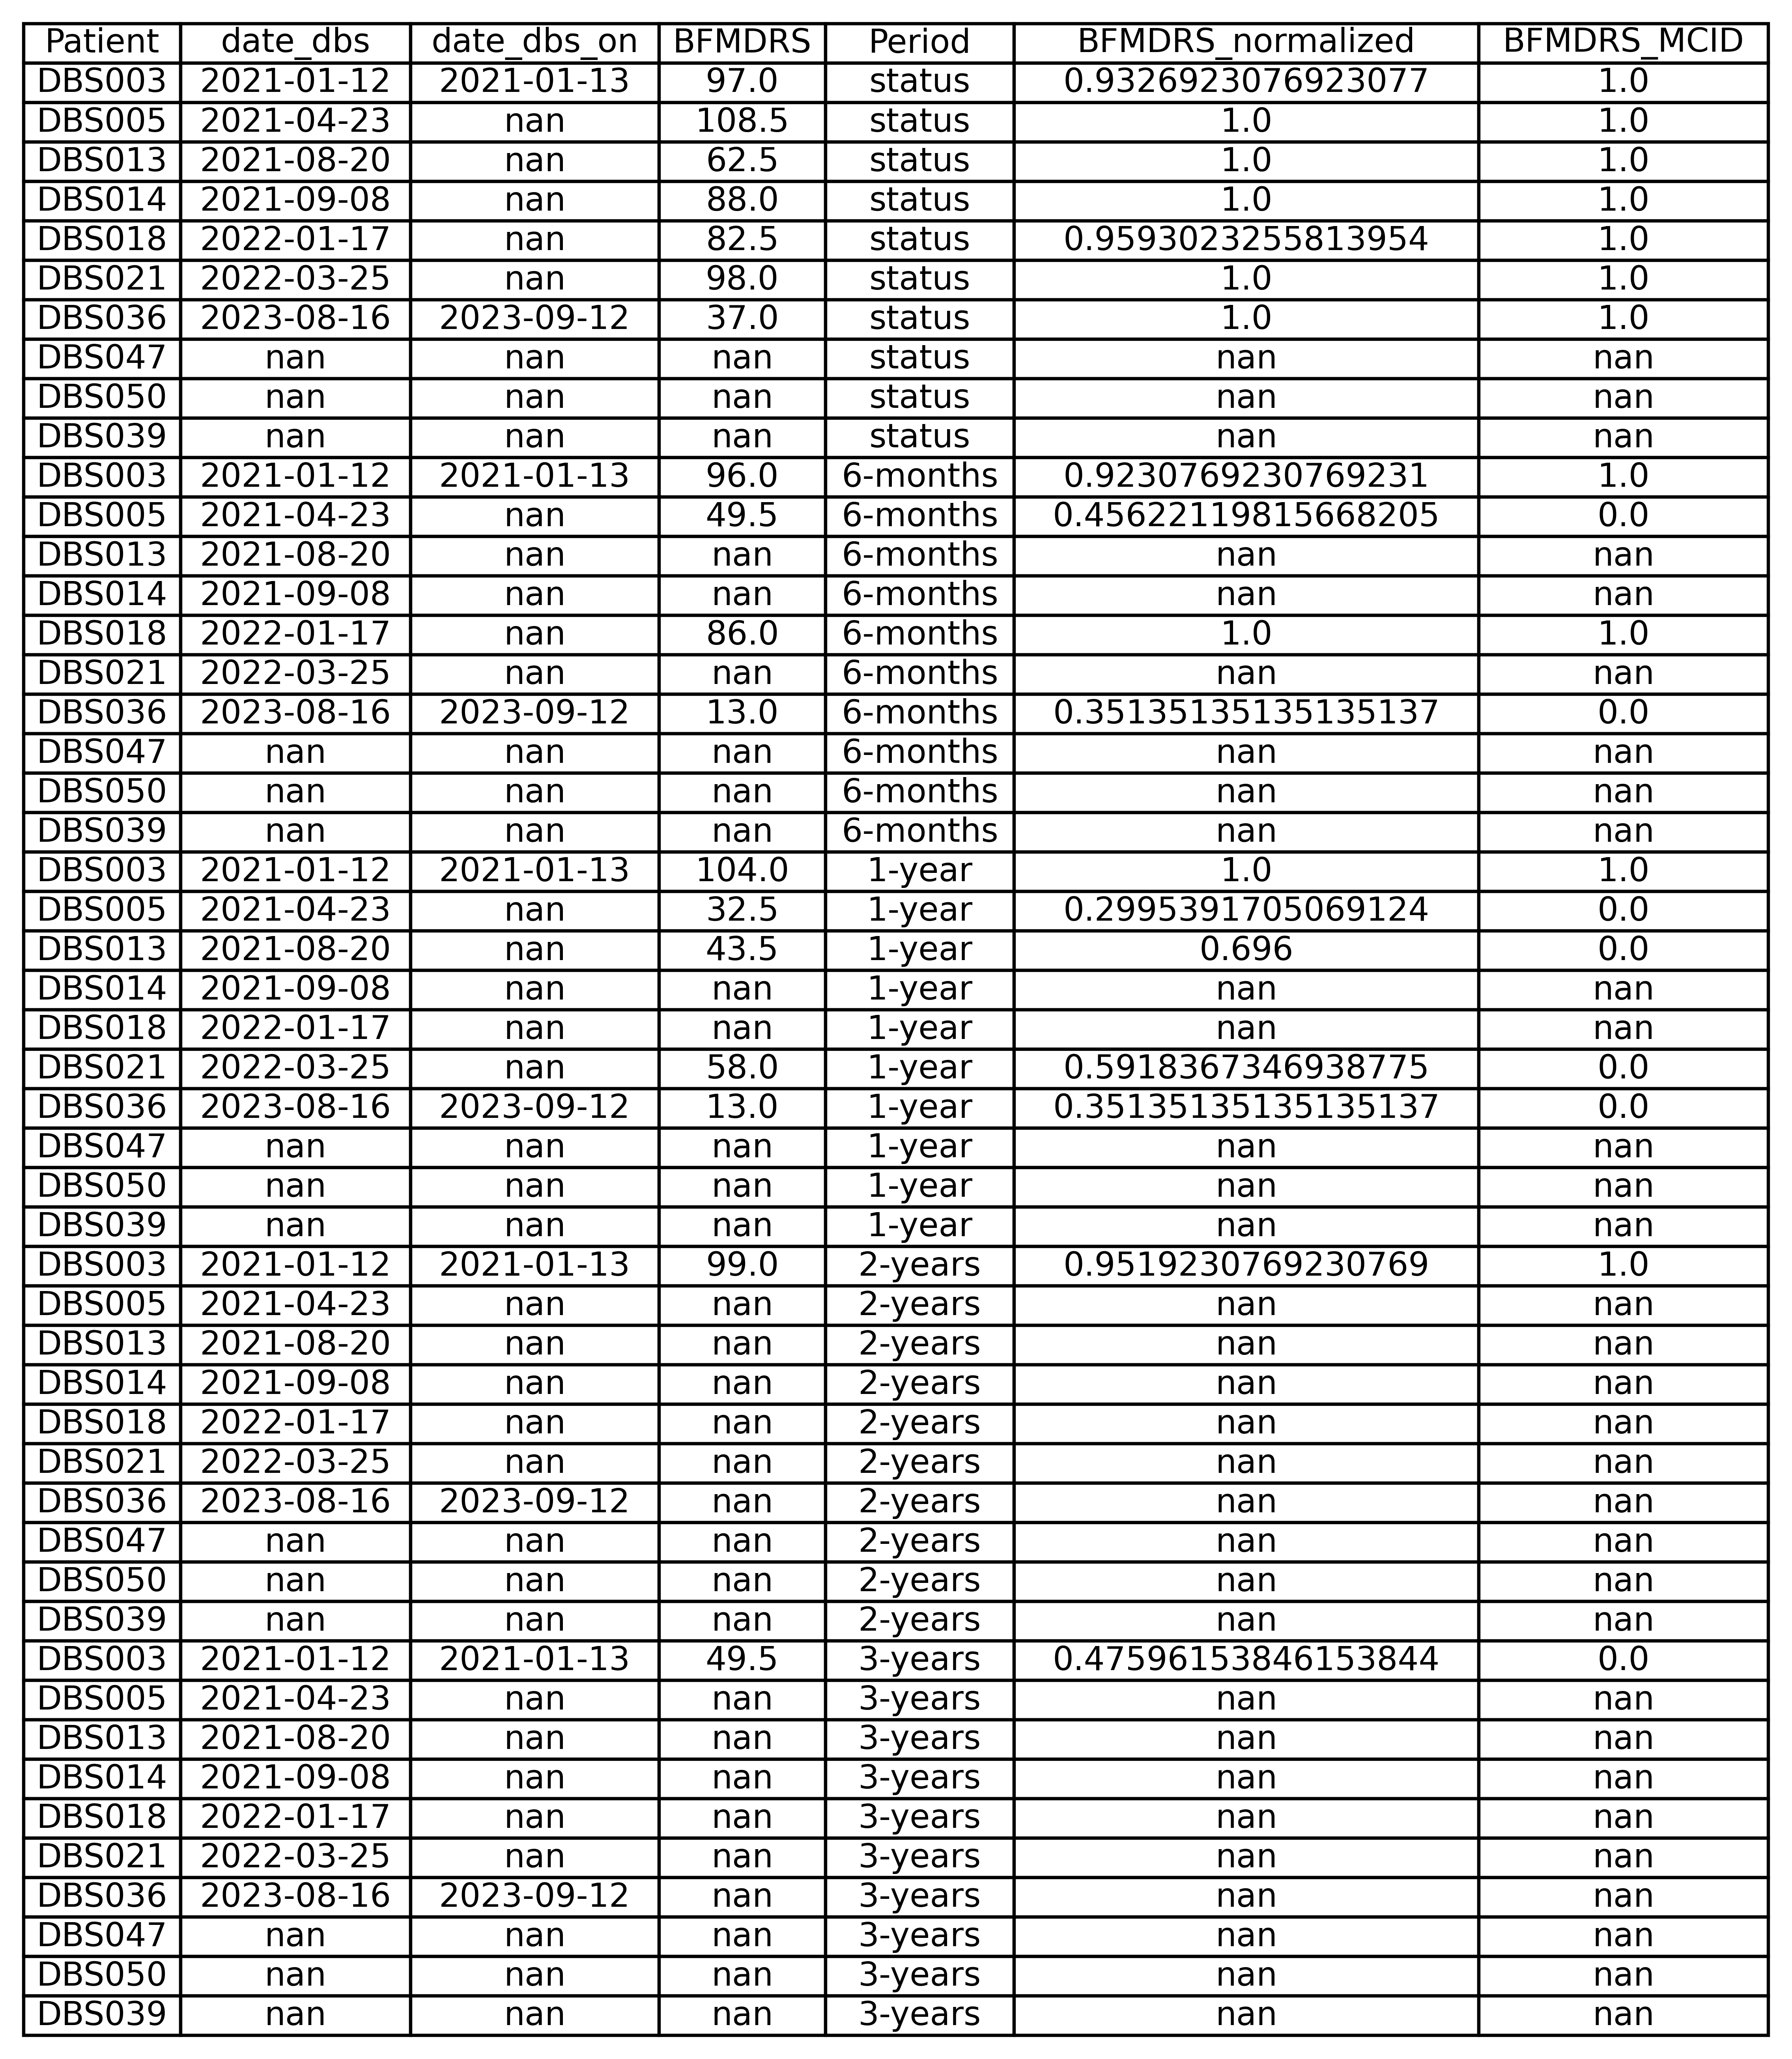

In [6]:
import matplotlib.pyplot as plt

# Create a figure and a single subplot
fig, ax = plt.subplots()

ax.axis('tight')
ax.axis('off')

# Create a table using the DataFrame data
table = ax.table(cellText=demographics_long_df.values, 
                 colLabels=demographics_long_df.columns, 
                 cellLoc='center', 
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(demographics_long_df.columns))))

In [7]:
#EXTRACT PEAK FOFOF DATA FOR CLOSEST DATES TO 6-mo, 1-yr, 2-yr, 3-yr post-implant, BUT AVERAGINE THE n-CLOSEST DATA POINTS

#First: function to find the closest 2 dates
# Modified function to find the closest dates and calculate the average
def find_average_closest_dates_within_range(df):
    result_rows = []
    n_closest = 3
    
    for _, group in df.groupby('Patient'):
        implant_date = group.iloc[0]['Implant date']
        target_dates = {
            'status': implant_date + pd.DateOffset(days=1),
            '6-months': implant_date + pd.DateOffset(months=6),
            '1-year': implant_date + pd.DateOffset(years=1),
            '2-years': implant_date + pd.DateOffset(years=2),
            '3-years': implant_date + pd.DateOffset(years=3)
        }
        
        for period, target_date in target_dates.items():
            # Calculate the difference between RecordingStartTime and the target date
            group['DateDiff'] = (group['RecordingStartTime'] - target_date).abs()
            closest_rows = group[group['DateDiff'] <= pd.Timedelta(days=180)].nsmallest(n_closest, 'DateDiff')
            
            if not closest_rows.empty:
                avg_row = closest_rows.mean(numeric_only=True).to_frame().T
                avg_row['Patient'] = group.iloc[0]['Patient']
                avg_row['Period'] = period
                result_rows.append(avg_row)
    
    return pd.concat(result_rows).reset_index(drop=True) if result_rows else pd.DataFrame()

#alternate version of function, whre implant_date is pre-specified and not extracted from the input dataframe
def find_average_closest_dates_within_range_implantDateSpecified(df, implant_date):
    result_rows = []
    n_closest = 3
    
    for _, group in df.groupby('Patient'):
        target_dates = {
            'status': implant_date + pd.DateOffset(days=1),
            '6-months': implant_date + pd.DateOffset(months=6),
            '1-year': implant_date + pd.DateOffset(years=1),
            '2-years': implant_date + pd.DateOffset(years=2),
            '3-years': implant_date + pd.DateOffset(years=3)
        }
        
        for period, target_date in target_dates.items():
            # Calculate the difference between RecordingStartTime and the target date
            group['DateDiff'] = (group['RecordingStartTime'] - target_date).abs()
            closest_rows = group[group['DateDiff'] <= pd.Timedelta(days=180)].nsmallest(n_closest, 'DateDiff')
            
            if not closest_rows.empty:
                avg_row = closest_rows.mean(numeric_only=True).to_frame().T
                avg_row['Patient'] = group.iloc[0]['Patient']
                avg_row['Period'] = period
                result_rows.append(avg_row)
    
    return pd.concat(result_rows).reset_index(drop=True) if result_rows else pd.DataFrame()


#NOT OF RELEVANCE TO THIS STUDY, INCLUDED FOR EASE OF RUNNING CODE
def extract_coherence(patient_coh_full_df, channel_conn):
    conn_band = [1,30] #TOTAL onnectivity in band of interest - will split into 3 (theta, beta, alpha)
    conn_band_theta = [3,7] #Connectivity in theta band
    conn_band_beta = [12.5,30] #Connectivity in beta band
    conn_band_alpha = [7,12.5] #Connectivity in alpha band

    channel_conn_string = channel_conn[0] + '-' + channel_conn[1]
    channel_conn_right = channel_conn[0] + '_RIGHT' + '-' + channel_conn[1] + '_RIGHT'
    channel_conn_left = channel_conn[0] + '_LEFT' + '-' + channel_conn[1] + '_LEFT'

    coh_IDvalues = patient_coh_full_df[
        (patient_coh_full_df['ChannelConn'] == channel_conn_right) | 
        (patient_coh_full_df['ChannelConn'] == channel_conn_left)
    ]

    freqs = [col for col in coh_IDvalues.columns if re.search(r'\d', col)]
    freqs_np = np.array(freqs)

    Cxy_band = coh_IDvalues[freqs]
    #Only average the columns that are within the connectivity band of interest
    columns_to_average_theta = [str(col) for col in Cxy_band.columns if float(col) >= conn_band_theta[0] and float(col) <= conn_band_theta[1]]
    columns_to_average_beta = [str(col) for col in Cxy_band.columns if float(col) >= conn_band_beta[0] and float(col) <= conn_band_beta[1]]
    columns_to_average_alpha = [str(col) for col in Cxy_band.columns if float(col) >= conn_band_alpha[0] and float(col) <= conn_band_alpha[1]]
    #conn_freqs = set([i for i, x in enumerate(freqs_np) if x >= conn_band[0] and x <= conn_band[1]])

    # Extract values from x at indices specified in y
    Cxy_band_average_theta = Cxy_band[columns_to_average_theta].mean(axis=1)
    Cxy_band_average_beta = Cxy_band[columns_to_average_beta].mean(axis=1)
    Cxy_band_average_alpha = Cxy_band[columns_to_average_alpha].mean(axis=1)
    
    coh_IDvalues['AverageCoherence_theta'] = Cxy_band_average_theta
    coh_IDvalues['AverageCoherence_alpha'] = Cxy_band_average_alpha
    coh_IDvalues['AverageCoherence_beta'] = Cxy_band_average_beta

    #Remove the columns freqs from the dataframe coh_IDvalues
    coh_IDvalues = coh_IDvalues.drop(freqs, axis=1)

    return coh_IDvalues

#Next, extract the data for the closest dates
all_PeakParams_df = pd.DataFrame() #will store all patient Peak param data in one dataframe
all_LFPParams_df = pd.DataFrame() #will store all patient LFP band param data in one dataframe
all_CohParams_df = pd.DataFrame() #will store all patient Coherence param data in one dataframe
all_BurstParams_df = pd.DataFrame() #will store all patient Burst param data in one dataframe
#Import basic patient data, used PSD file to get the patient data (arbitrarily chosen)
PSD_df = pd.read_csv(resultsDir + resultsPSDFilename)
PSD_df['RecordingType'] = PSD_df['RecordingType'].replace('CT', 'CT (stim on)')

patList = PSD_df['Patient'].unique() #patList = ['DBS003'], hemisphere = 'RIGHT'
#patList = ['DBS036']

#Load the file for adjacent coherence across all patients
resultsCohDataFileName = resultsDir + resultsCohPredetFilename
results_coh_df = pd.read_csv(resultsCohDataFileName)

#Load the file for bursting data across all patients
resultsBurstFileName = os.path.join(resultsDir, 'All_Patients_BetaBurst_Results.csv')
results_burst_df = pd.read_csv(resultsBurstFileName)

for patient in patList:
    for hemisphere in ['LEFT', 'RIGHT']:
        if (patient=='DBS003' and hemisphere=='LEFT') or (patient=='DBS009') or (patient=='DBS021' and hemisphere=='LEFT') or (patient=='DBS013' and hemisphere=='LEFT') or (patient=='DBS005' and hemisphere=='LEFT') or (patient=='DBS014' and hemisphere=='RIGHT') or (patient=='DBS036' and hemisphere=='LEFT') or (patient=='DBS018' and hemisphere=='RIGHT') or (patient=='DBS047' and hemisphere=='RIGHT') or (patient=='DBS050' and hemisphere=='RIGHT') or (patient=='DBS039' and hemisphere=='RIGHT'):
            continue

        patient_data = PSD_df[PSD_df['Patient'] == patient]
        if patient_data.empty:
            print('No data for patient', patient)
            continue
        #Load PSDPeak data
        patientPSDPeakDataFileName = resultsPSDPeaksDir + patient + '_' + hemisphere + '_PSDPeaks.csv'
        patient_PSDPeak_df = pd.read_csv(patientPSDPeakDataFileName)

        #Load LFP band power data
        patientLFPPowersDataFileName = resultsLFPPowersDir + patient + '_' + hemisphere + '_LFPPowers.csv'
        patient_LFPPowers_df = pd.read_csv(patientLFPPowersDataFileName)

        #Load PSD data - to get just peak beta power
        patientPSDDataFileName = resultsPSDsDir + patient + '_' + hemisphere + '_PSDs.csv'
        patient_PSD_df = pd.read_csv(patientPSDDataFileName)

        #Use custom function extract_peak_powers to get the power around peak
        patient_peak_powers_df = extract_peak_powers(patient_PSD_df, patient_PSDPeak_df[['Peak CF']], 2.5)
        patient_PSDPeak_df = pd.concat([patient_PSDPeak_df, patient_peak_powers_df], axis=1)

        patient_PSD_df['Implant date'] = pd.to_datetime(patient_PSD_df['Implant date'])
        patient_PSD_df['RecordingStartTime'] = pd.to_datetime(patient_PSD_df['RecordingStartTime'])

        #Get the coherence specifically for this patient
        channel_conn = ['ZERO_ONE','TWO_THREE']

        patient_coh_full_df = results_coh_df[(results_coh_df['Patient'] == patient)]
        patient_coh_df = extract_coherence(patient_coh_full_df, channel_conn)

        #Get the bursting data specifically for this patient
        patient_burst_df = results_burst_df[(results_burst_df['Patient'] == patient)]
        patient_burst_df['RecordingStartTime'] = pd.to_datetime(patient_burst_df['RecordingStartTime'])

        #just get the Interval type (Status vs OneYear) and Peak metrics for each patient
        #PSD_IDpowers = patient_PSDPeak_df.drop(['Patient','Implant date','StatusDysStart','Discharge','RecordingStartTime','RecordingType','Channel'], axis=1)
        #only get the columns in the dataframe that have numbers as column names - these are the columns that have frequency values as their names

        # Convert 'Implant date' and 'RecordingStartTime' to datetime format
        patient_PSDPeak_df['Implant date'] = pd.to_datetime(patient_PSDPeak_df['Implant date'])
        patient_PSDPeak_df['RecordingStartTime'] = pd.to_datetime(patient_PSDPeak_df['RecordingStartTime'])
        patient_LFPPowers_df['Implant date'] = pd.to_datetime(patient_LFPPowers_df['Implant date'])
        patient_LFPPowers_df['RecordingStartTime'] = pd.to_datetime(patient_LFPPowers_df['RecordingStartTime'])
        patient_coh_df['Implant date'] = pd.to_datetime(patient_coh_df['Implant date'])
        patient_coh_df['RecordingStartTime'] = pd.to_datetime(patient_coh_df['RecordingStartTime'])

        #Add column for linear representation of Peak PW, converted from log scale
        patient_PSDPeak_df['Peak PW Linear'] = 10**(patient_PSDPeak_df['Peak PW'])

        #Normalize the columns Peak PW, BetaPower, ThetaPower, DeltaPower, AlphaPower, GammaPower, HighBetaPower, LowBetaPower, LowGammaPower, HighGammaPower
        if normalize_LFP_columns:
            patient_PSDPeak_df['Peak Power'] = patient_PSDPeak_df['Peak Power'] / patient_PSDPeak_df['Peak Power'].max()
            patient_PSDPeak_df['Peak PW'] = patient_PSDPeak_df['Peak PW'] / patient_PSDPeak_df['Peak PW'].max()
            patient_PSDPeak_df['Peak PW Linear'] = patient_PSDPeak_df['Peak PW Linear'] / patient_PSDPeak_df['Peak PW Linear'].max()
            patient_LFPPowers_df['BetaPower'] = patient_LFPPowers_df['BetaPower'] / patient_LFPPowers_df['BetaPower'].max()
            patient_LFPPowers_df['ThetaPower'] = patient_LFPPowers_df['ThetaPower'] / patient_LFPPowers_df['ThetaPower'].max()
            patient_LFPPowers_df['DeltaPower'] = patient_LFPPowers_df['DeltaPower'] / patient_LFPPowers_df['DeltaPower'].max()
            patient_LFPPowers_df['AlphaPower'] = patient_LFPPowers_df['AlphaPower'] / patient_LFPPowers_df['AlphaPower'].max()
            patient_LFPPowers_df['GammaPower'] = patient_LFPPowers_df['GammaPower'] / patient_LFPPowers_df['GammaPower'].max()
            patient_LFPPowers_df['HighBetaPower'] = patient_LFPPowers_df['HighBetaPower'] / patient_LFPPowers_df['HighBetaPower'].max()
            patient_LFPPowers_df['LowBetaPower'] = patient_LFPPowers_df['LowBetaPower'] / patient_LFPPowers_df['LowBetaPower'].max()
            patient_LFPPowers_df['LowGammaPower'] = patient_LFPPowers_df['LowGammaPower'] / patient_LFPPowers_df['LowGammaPower'].max()
            patient_coh_df['AverageCoherence_theta'] = patient_coh_df['AverageCoherence_theta'] / patient_coh_df['AverageCoherence_theta'].max()
            patient_coh_df['AverageCoherence_alpha'] = patient_coh_df['AverageCoherence_alpha'] / patient_coh_df['AverageCoherence_alpha'].max()
            patient_coh_df['AverageCoherence_beta'] = patient_coh_df['AverageCoherence_beta'] / patient_coh_df['AverageCoherence_beta'].max()
            patient_burst_df['AvgBurstAmplitude'] = patient_burst_df['AvgBurstAmplitude'] / patient_burst_df['AvgBurstAmplitude'].max()


        # Apply the function to find the closest dates
        pat_PeakParams_df = find_average_closest_dates_within_range(patient_PSDPeak_df)
        pat_LFPParams_df = find_average_closest_dates_within_range(patient_LFPPowers_df)
        pat_CohParams_df = find_average_closest_dates_within_range(patient_coh_df)
        pat_BurstParams_df = find_average_closest_dates_within_range_implantDateSpecified(patient_burst_df,patient_LFPPowers_df['Implant date'].iloc[0])

        #Add the peak data (based on time-point) to the all_PeakParams_df
        all_PeakParams_df = pd.concat([all_PeakParams_df, pat_PeakParams_df], ignore_index=True)
        all_LFPParams_df = pd.concat([all_LFPParams_df, pat_LFPParams_df], ignore_index=True)
        all_CohParams_df = pd.concat([all_CohParams_df, pat_CohParams_df], ignore_index=True)
        all_BurstParams_df = pd.concat([all_BurstParams_df, pat_BurstParams_df], ignore_index=True)

#COMBINE DEMOGRAPHICS DATA WITH PEAK PARAMS DATA
all_data_df = pd.merge(all_PeakParams_df, demographics_long_df, on=['Patient', 'Period'], how='inner')
all_data_df = pd.merge(all_data_df, all_LFPParams_df, on=['Patient', 'Period'], how='inner')
all_data_df = pd.merge(all_data_df, moredemographics_long_df, on=['Patient', 'Period'], how='inner')
all_data_df = pd.merge(all_data_df, all_CohParams_df, on=['Patient', 'Period'], how='inner')
all_data_df = pd.merge(all_data_df, all_BurstParams_df, on=['Patient', 'Period'], how='inner')
all_data_df.drop(columns=['date_dbs', 'date_dbs_on'], inplace=True)

all_data_df = all_data_df.rename(columns={'Peak Power': 'PeakPower'})
all_data_df = all_data_df.rename(columns={'Peak PW': 'PeakPW'})
all_data_df = all_data_df.rename(columns={'Peak CF': 'PeakCF'})
all_data_df = all_data_df.rename(columns={'Peak BW': 'PeakBW'})
all_data_df = all_data_df.rename(columns={'Aperiodic Offset': 'AperiodicOffset'})
all_data_df = all_data_df.rename(columns={'Aperiodic Exponent': 'AperiodicExponent'})
all_data_df = all_data_df.rename(columns={'Peak PW Linear': 'PeakPWlinear'})

#remove duplicate rows
all_data_df = all_data_df.drop_duplicates(keep='first')

# Display all rows in the Jupyter Notebook
pd.set_option('display.max_rows', None)  # Set max rows to None to display all rows
display(all_data_df)  # Use display in Jupyter, or print(all_data_df) in a standard script
pd.reset_option('display.max_rows')

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_811/3044547282.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  power_sum = sum(psd_row[range_freqs])
/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_811/1214863399.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_burst_df['RecordingStartTime'] = pd.to_datetime(patient_burst_df['RecordingStartTime'])
/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_811/1214863399.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

PeakCF    PeakPW     PeakBW  AperiodicOffset  AperiodicExponent  \
0   22.892165  0.926653   5.851465        -0.624805           1.265094   
1   22.023079  0.313877   6.247399        -0.877452           0.894296   
2   24.524608  0.475662   7.389430        -0.473715           1.376980   
3   30.873694  0.277910   5.580118        -0.585243           1.225204   
4   20.032324  0.398612   7.444993        -0.479182           1.301798   
5   27.458942  0.687517   8.074482        -0.598660           1.419433   
6   26.586158  0.641608   5.768935        -0.636409           1.337223   
7   20.581027  0.267457   4.154632        -0.378890           1.376754   
8   16.192357  0.511898   7.163076        -0.416194           1.426846   
9   22.210180  0.179512   5.551422        -0.398639           1.342655   
10  14.837426  0.915518   6.126973        -0.067996           1.853822   
11  16.335965  1.000000   6.545477        -0.183545           1.672691   
12  18.254085  0.807430   4.405045        -0.113358           1.809747   
13  15.572000  0.379893   4.219202        -0.349995           1.473931   
14  18.615925  0.813484   8.725324         0.105456           2.133686   
15  16.412432  0.584420  10.609799         0.173033           2.099273   
16  16.835517  0.643973  10.003863         0.293157           2.310893   
17  23.592154  0.636451  12.000000         0.228981           2.160928   
18  15.467462  0.887095   8.561754        -0.258487           1.851769   
19  13.397589  0.556113   5.798716        -0.045706           1.934051   
20  15.286413  0.491898   8.040661        -0.058261           1.918394   
21  20.951747  0.821349   4.339059        -0.415763           1.435640   
22  24.823650  0.384972   5.271829        -0.266787           1.580458   
23  32.326189  0.491165   3.259377        -0.464149           1.381273   
24   8.477688  0.482437   2.177635         0.172890           2.256621   
25  14.428551  0.754898   5.408838        -0.651974           1.338308   
26  36.949203  0.365519   7.741766        -0.215596           1.795873   
27  13.212593  0.460888   3.967928        -0.352967           1.654278   

    PeakPower  PeakPWlinear Patient    Period  BFMDRS  ...  promis_p_total  \
0    0.664760      0.864301  DBS003    status    97.0  ...            28.0   
1    0.332670      0.198051  DBS003  6-months    96.0  ...             5.0   
2    0.489120      0.335500  DBS003    1-year   104.0  ...             NaN   
3    0.223240      0.183693  DBS003   2-years    99.0  ...            16.0   
4    0.308904      0.245218  DBS003   3-years    49.5  ...             NaN   
5    0.483469      0.664517  DBS005    status   108.5  ...             NaN   
6    0.577160      0.623016  DBS005  6-months    49.5  ...             6.0   
7    0.165851      0.138970  DBS013  6-months     NaN  ...             NaN   
8    0.391379      0.316732  DBS013    1-year    43.5  ...             NaN   
9    0.122987      0.109737  DBS013   2-years     NaN  ...             NaN   
10   0.832103      0.863725  DBS014    status    88.0  ...            32.0   
11   1.000000      1.000000  DBS014  6-months     NaN  ...             NaN   
12   0.167389      0.732371  DBS018    status    82.5  ...             NaN   
13   0.140953      0.313782  DBS018  6-months    86.0  ...            24.0   
14   0.457795      0.685806  DBS021    status    98.0  ...             NaN   
15   0.351673      0.421235  DBS021  6-months     NaN  ...            32.0   
16   0.336518      0.476486  DBS021    1-year    58.0  ...            31.0   
17   0.174140      0.491126  DBS021   2-years     NaN  ...             NaN   
18   0.807329      0.724180  DBS036    status    37.0  ...            32.0   
19   0.446274      0.260587  DBS036  6-months    13.0  ...             NaN   
20   0.298138      0.209501  DBS036    1-year    13.0  ...             NaN   
21   0.221559      0.780008  DBS047    status     NaN  ...            32.0   
22   0.041124      0.396822  DBS047  6-months     NaN  ...        

In [97]:
#export all_data_df to csv
all_data_df.to_csv(resultsDir + 'clinical+LFP_data_df.csv', index=False)

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_72304/2562513682.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedsql_data_df['ID_in_Paper'] = pedsql_data_df['Patient'].map(patient_id_mapping)


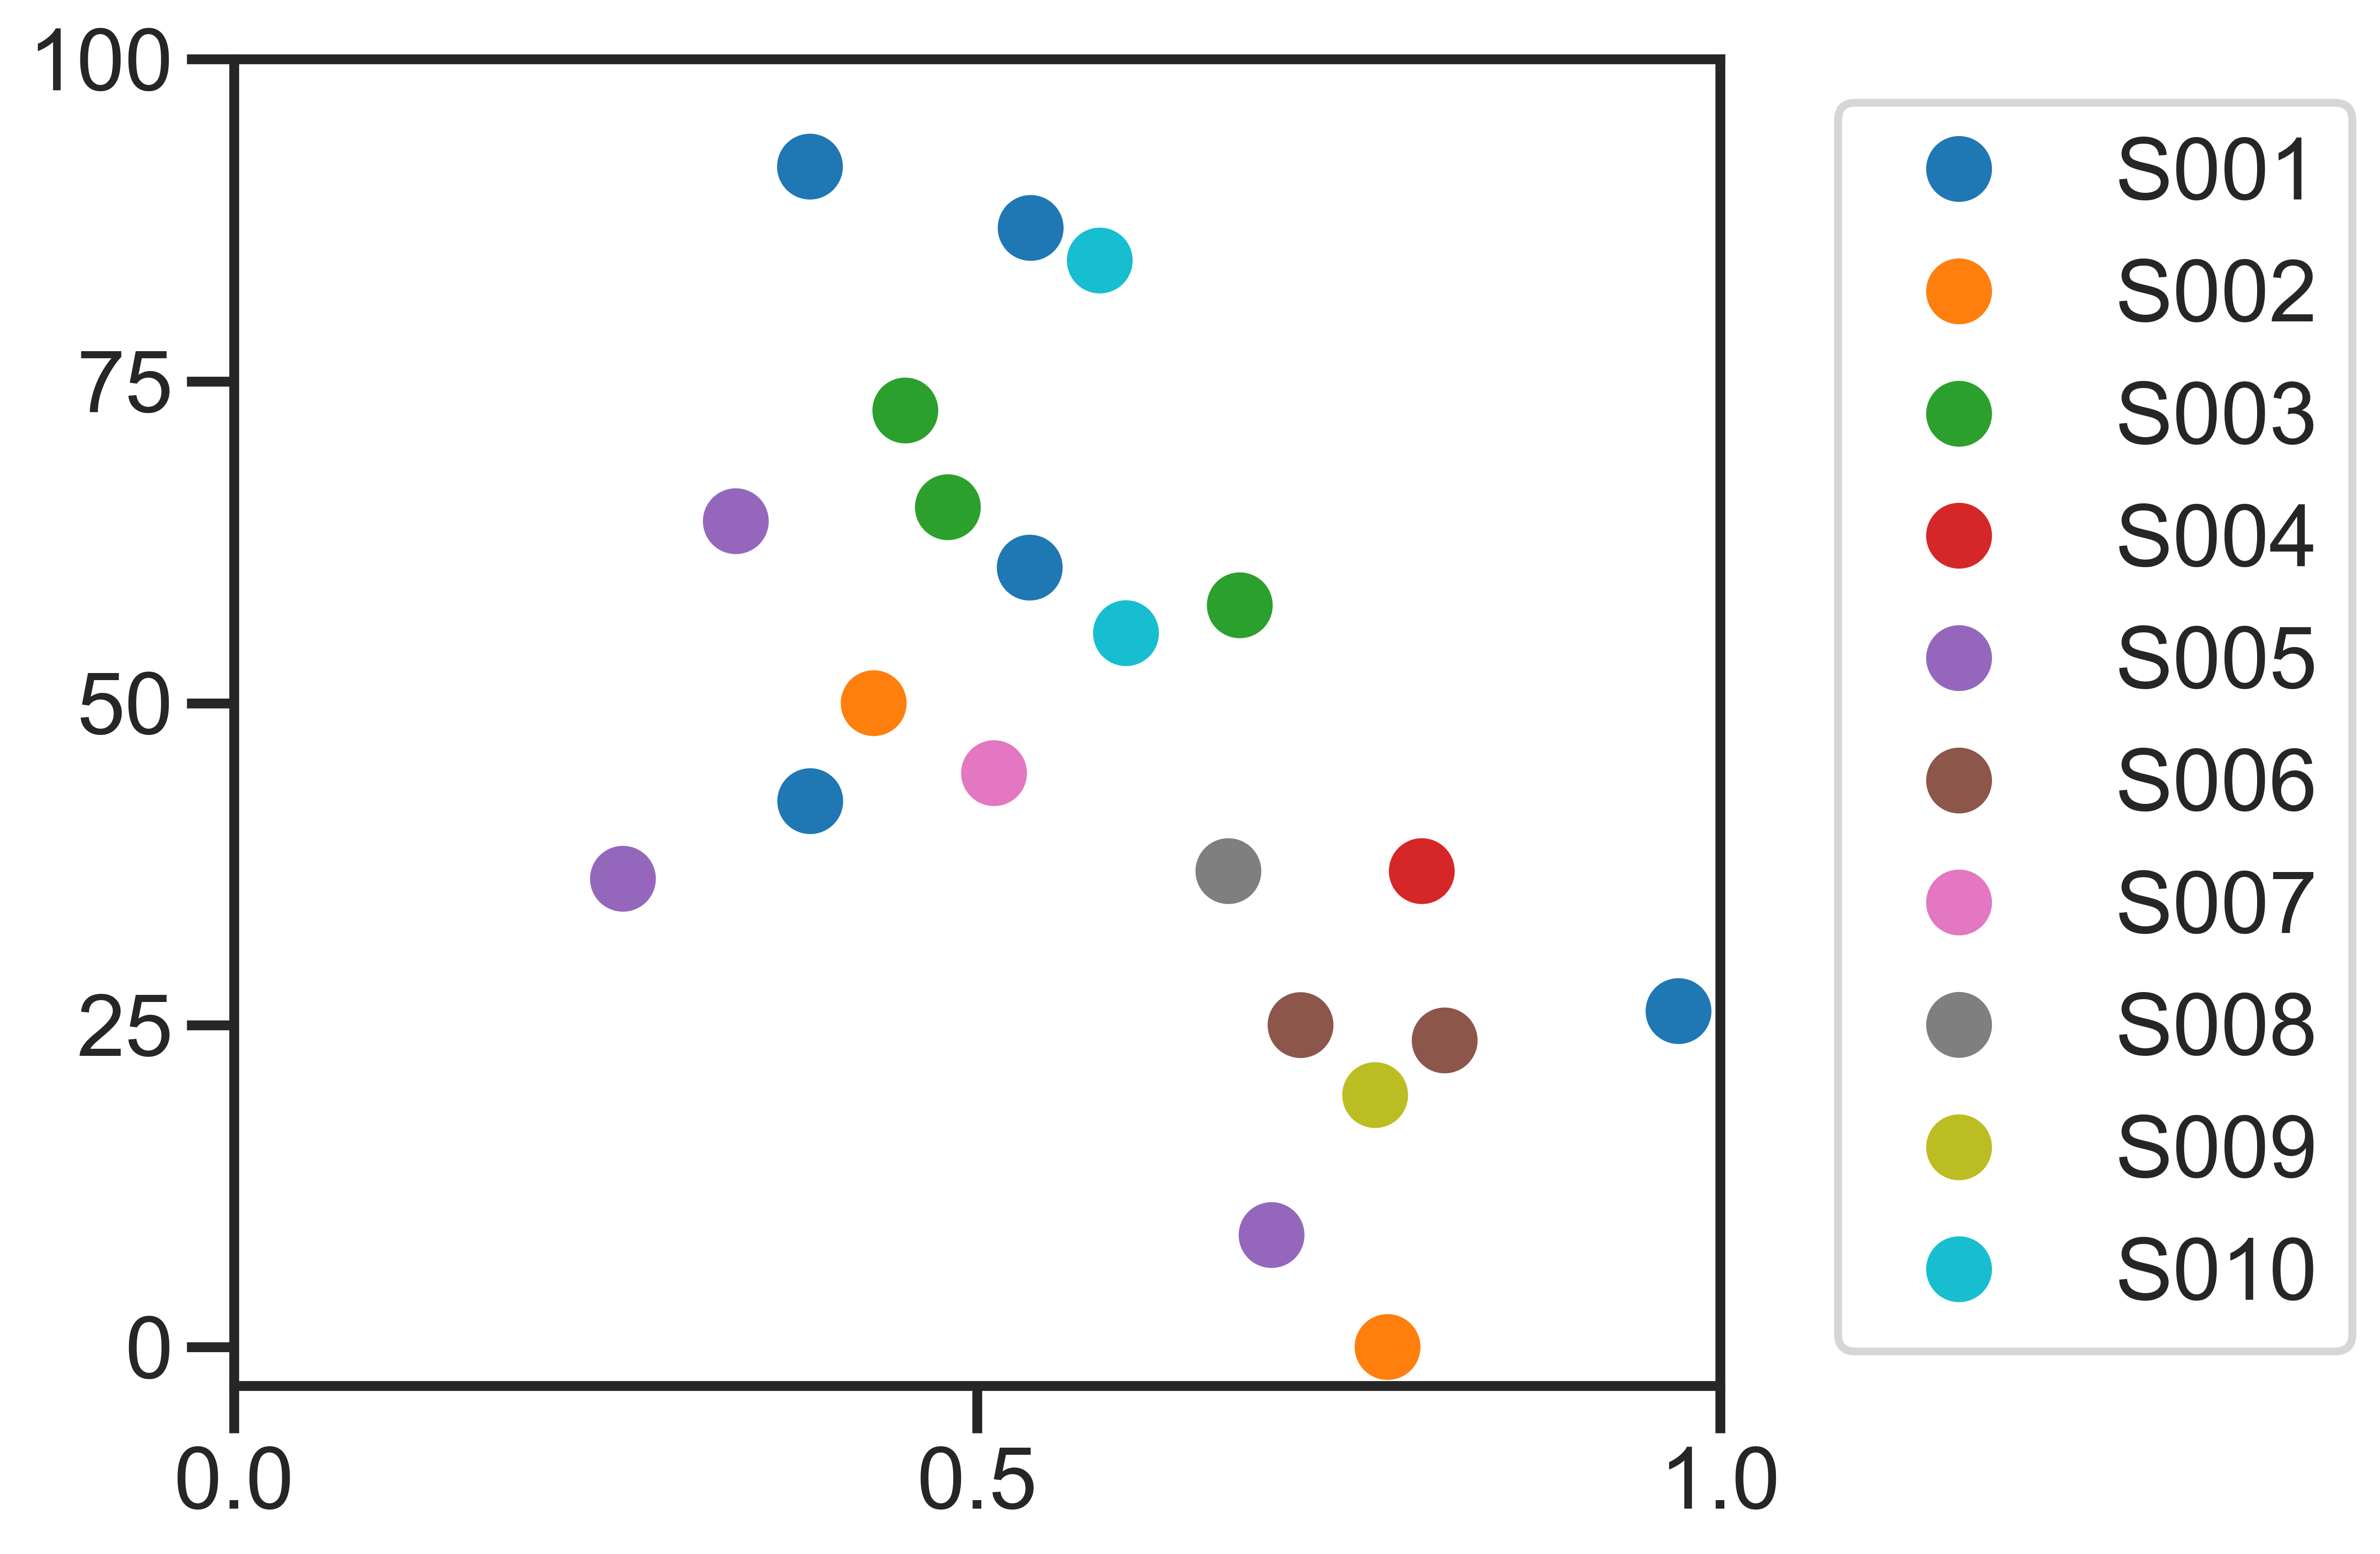

In [41]:
#PLOT PEDSQL vs Beta
# Define the mapping between Patient and ID in Paper
patient_id_mapping = {
    'DBS003': 'S001',
    'DBS005': 'S008',
    'DBS013': 'S002',
    'DBS014': 'S009',
    'DBS018': 'S010',
    'DBS021': 'S003',
    'DBS036': 'S004',
    'DBS039': 'S005',
    'DBS047': 'S006',
    'DBS050': 'S007'
}

# Replace the 'Patient' column values with the corresponding IDs in the mapping
pedsql_data_df['ID_in_Paper'] = pedsql_data_df['Patient'].map(patient_id_mapping)
# Define the desired order for the legend
id_order = ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']


plt.figure(figsize=(9, 6))
sns.set_context('poster')
#sns.set_context("notebook", font_scale=2.0, rc={"lines.linewidth": 2.0})
sns.set_style("ticks")
ax = sns.scatterplot(data=pedsql_data_df, x='BetaPower', y='total_score_pedsql', hue='ID_in_Paper', palette='tab10', s=330, hue_order=id_order)
# Label each point with the 'Patient' identifier
'''
for i in range(pedsql_data_df.shape[0]):
    plt.text(pedsql_data_df.BetaPower.iloc[i], 
             pedsql_data_df.total_score_pedsql.iloc[i], 
             pedsql_data_df.Patient.iloc[i],
             fontsize=9, 
             ha='right')  # Align the text to the right of the points
'''

#plt.title('BetaPower vs Total Score PedsQL')
plt.xlabel('Beta-Band Power [a.u.]')
plt.ylabel('PedsQL')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0,1)
plt.ylim(-3,100)
plt.xticks(np.arange(0, 1.05, 0.5))
plt.yticks(np.arange(0, 105, 25))
#ax.tick_params(labelsize=30)
#plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
ax.set(xlabel=None)
ax.set(ylabel=None)
#plt.grid(True)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_72304/4195412781.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedsql_data_df['BestFit'] = intercept + beta_power_slope * pedsql_data_df['BetaPower']


Linear mixed model fit by REML [’lmerMod’]
Formula: total_score_pedsql~BetaPower+BetaPower*intervalType+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 21	 Groups: {'Patient': 10.0}

Log-likelihood: -76.460 	 AIC: 164.921

Random effects:

                 Name      Var     Std
Patient   (Intercept)  182.552  13.511
Residual               305.551  17.480

No random effect correlations specified

Fixed effects:

                              Estimate   2.5_ci  97.5_ci      SE      DF  \
(Intercept)                     97.658   55.720  139.596  21.397  16.801   
BetaPower                      -92.781 -169.076  -16.486  38.927  15.989   
intervalTypestatus              14.985  -74.241  104.212  45.525  16.566   
BetaPower:intervalTypestatus   -11.638 -142.472  119.196  66.753  16.314   

                              T-stat  P-val  Sig  
(Intercept)                    4.564  0.000  ***  
BetaPower                     -2.383  0.030    *  
intervalTypestatus   

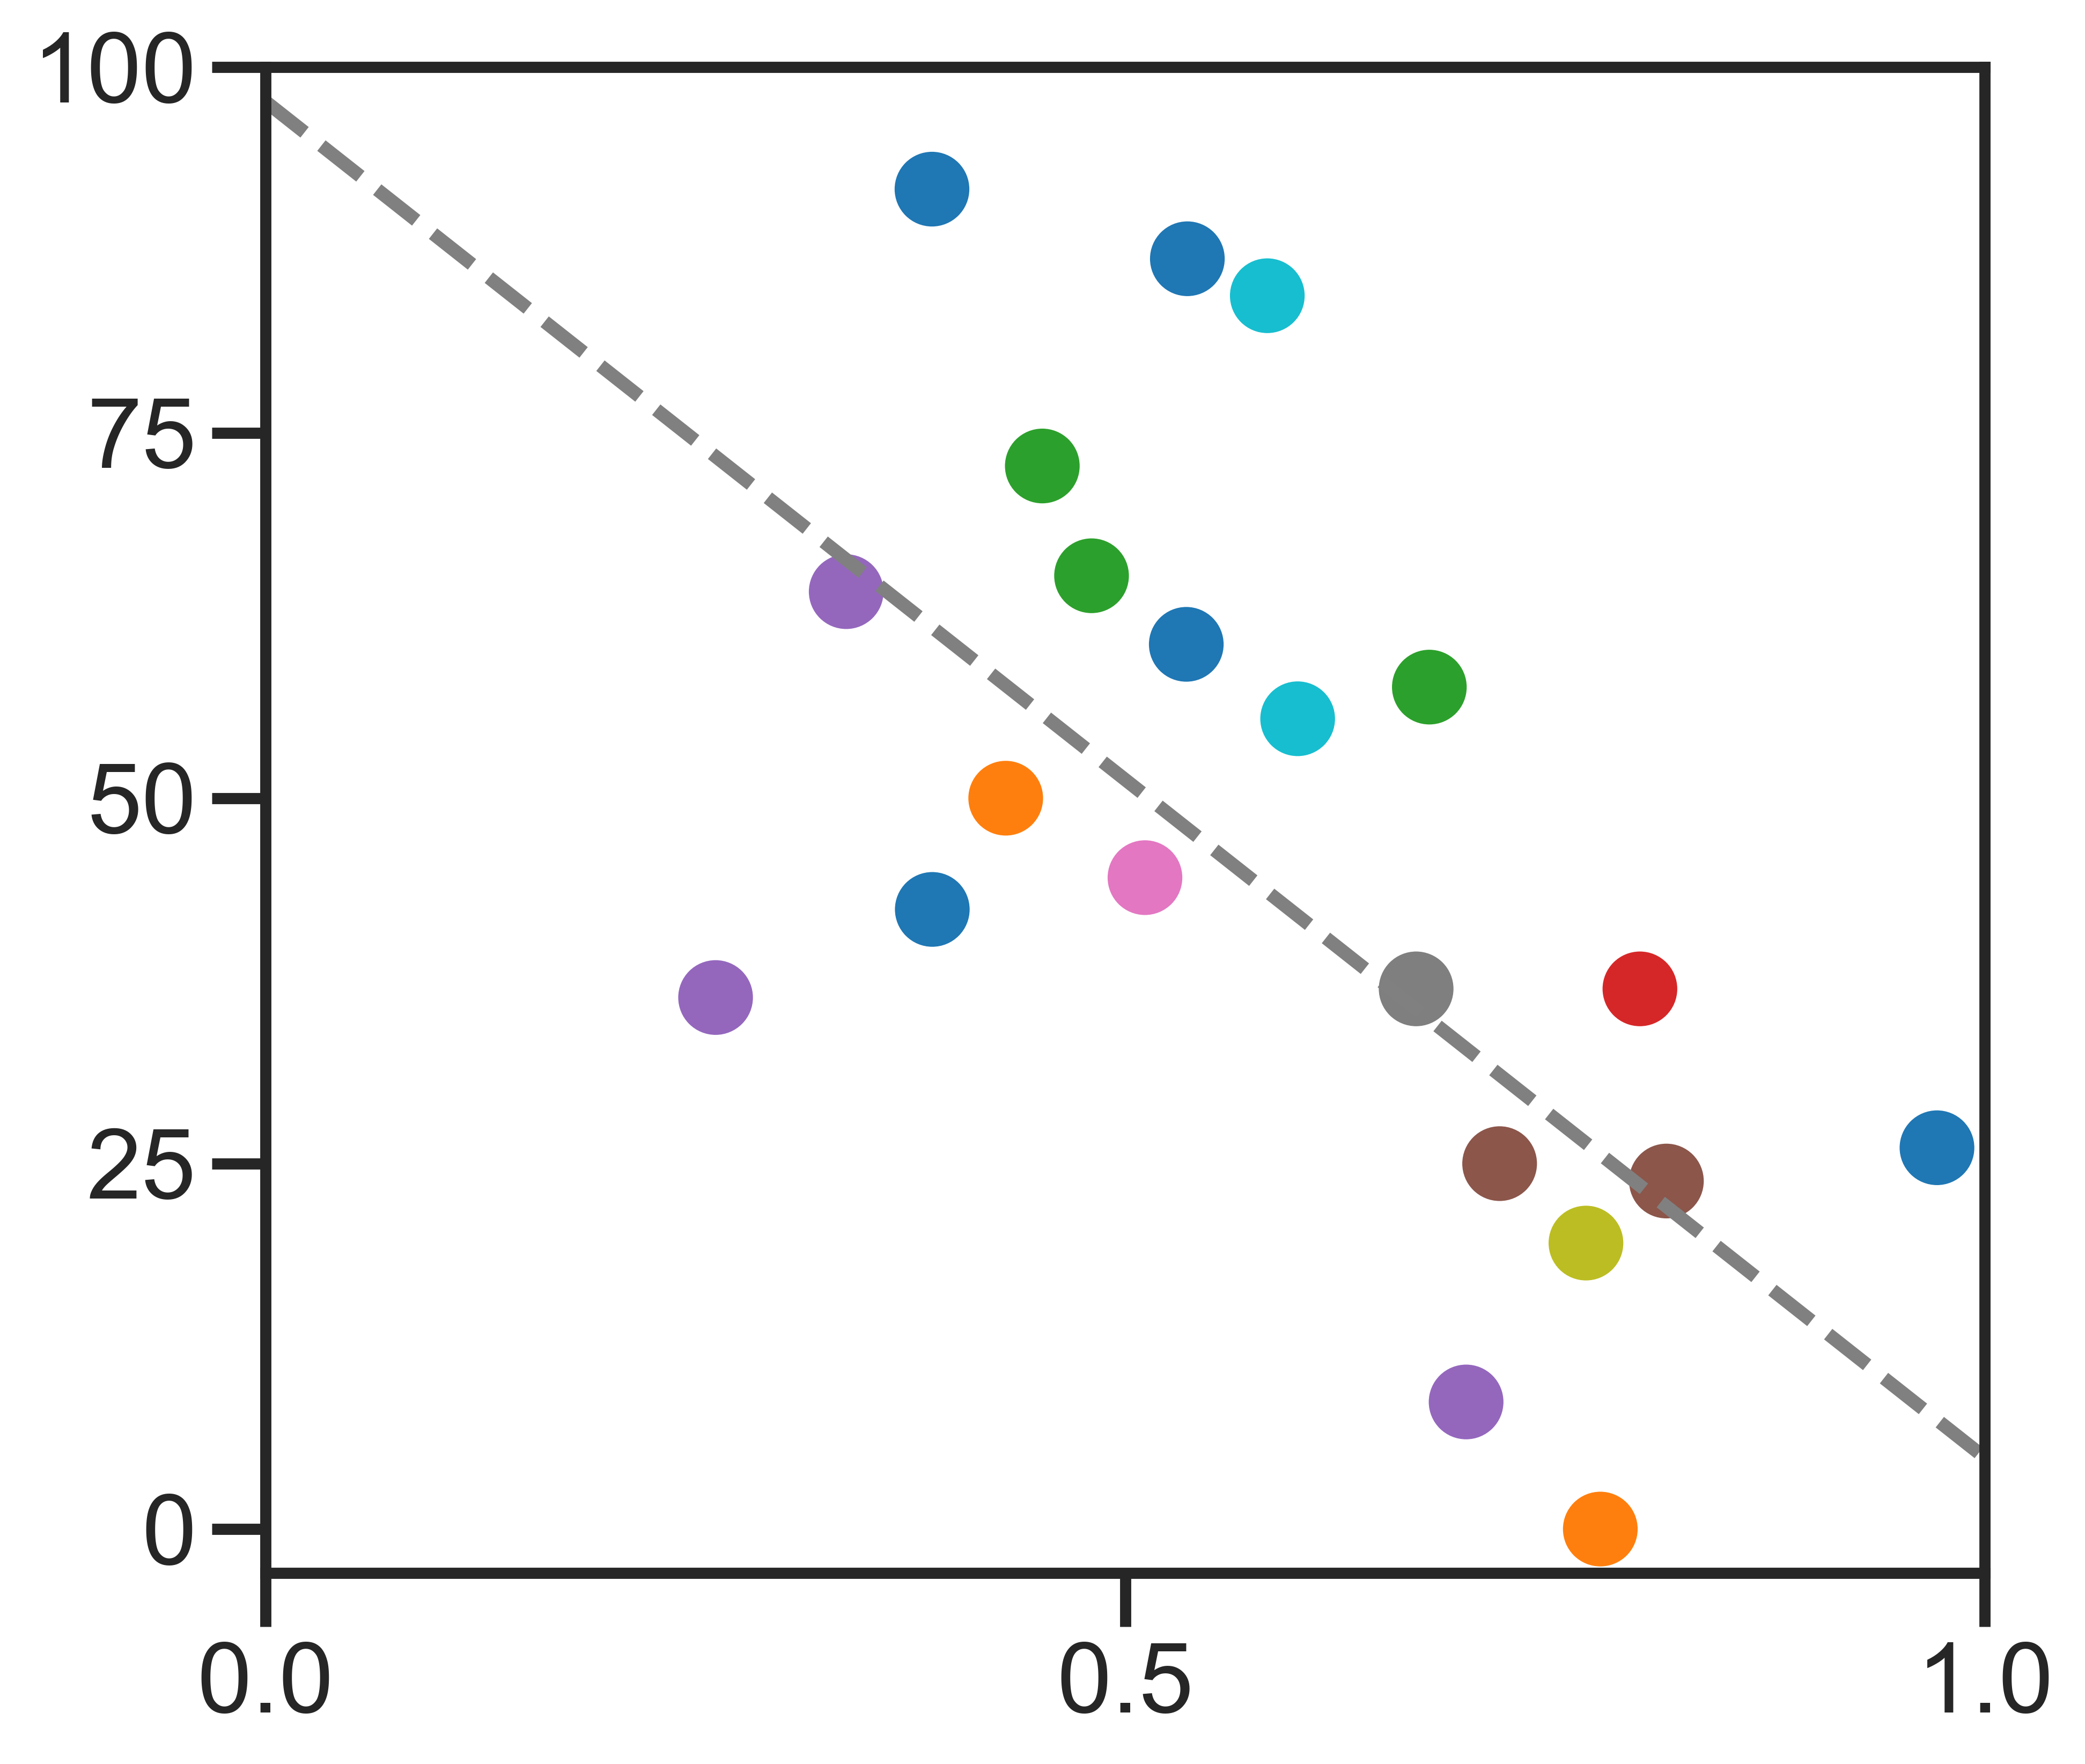

In [74]:
#PEDSQL VS BETA POWER + BEST FIT LINE
from pymer4.models import Lmer
from pymer4.stats import rsquared


# Fit the mixed-effects model
model = Lmer("total_score_pedsql ~ BetaPower + BetaPower*intervalType + (1|Patient)", 
             data=pedsql_data_df)
result = model.fit()
print(result)

# Extract coefficients for Intercept and BetaPower from the model summary
intercept = model.coefs['Estimate']['(Intercept)']
beta_power_slope = model.coefs['Estimate']['BetaPower']

# Extract the dependent variable (y), residuals (res), and calculate R-squared
y = pedsql_data_df['total_score_pedsql'].values  # Dependent variable as a 1D array
res = model.residuals  # Residuals as a 1D array
r2_values = rsquared(y, res)

# Calculate the predicted line of best fit
pedsql_data_df['BestFit'] = intercept + beta_power_slope * pedsql_data_df['BetaPower']

# Create the scatter plot
plt.figure(figsize=(7, 6))
sns.set_context('poster')
sns.set_style("ticks")

# Scatter plot of actual data
ax = sns.scatterplot(
    data=pedsql_data_df,
    x='BetaPower',
    y='total_score_pedsql',
    hue='ID_in_Paper',  # Use IDs for legend
    palette='tab10',
    s=330,
    hue_order=['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']
)

# Line plot for the line of best fit
x_vals = np.linspace(0, 1, 100)  # BetaPower range
y_vals = intercept + beta_power_slope * x_vals
plt.plot(x_vals, y_vals, color='grey', linestyle='--')

# Customize the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1)
plt.ylim(-3, 100)
plt.xticks(np.arange(0, 1.05, 0.5))
plt.yticks(np.arange(0, 105, 25))
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()

plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_72304/3559007035.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedsql_data_df['BestFit_alpha'] = intercept + alpha_power_slope * pedsql_data_df['AlphaPower']


Linear mixed model fit by REML [’lmerMod’]
Formula: total_score_pedsql~AlphaPower+AlphaPower*intervalType+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 21	 Groups: {'Patient': 10.0}

Log-likelihood: -80.617 	 AIC: 173.234

Random effects:

                 Name      Var     Std
Patient   (Intercept)   84.779   9.208
Residual               577.955  24.041

No random effect correlations specified

Fixed effects:

                               Estimate   2.5_ci  97.5_ci      SE      DF  \
(Intercept)                      41.305    3.223   79.388  19.430  10.079   
AlphaPower                       20.141  -45.784   86.066  33.636  12.981   
intervalTypestatus                8.425  -66.448   83.298  38.201  16.823   
AlphaPower:intervalTypestatus   -38.315 -148.320   71.690  56.126  16.990   

                               T-stat  P-val Sig  
(Intercept)                     2.126  0.059   .  
AlphaPower                      0.599  0.560      
intervalTypest

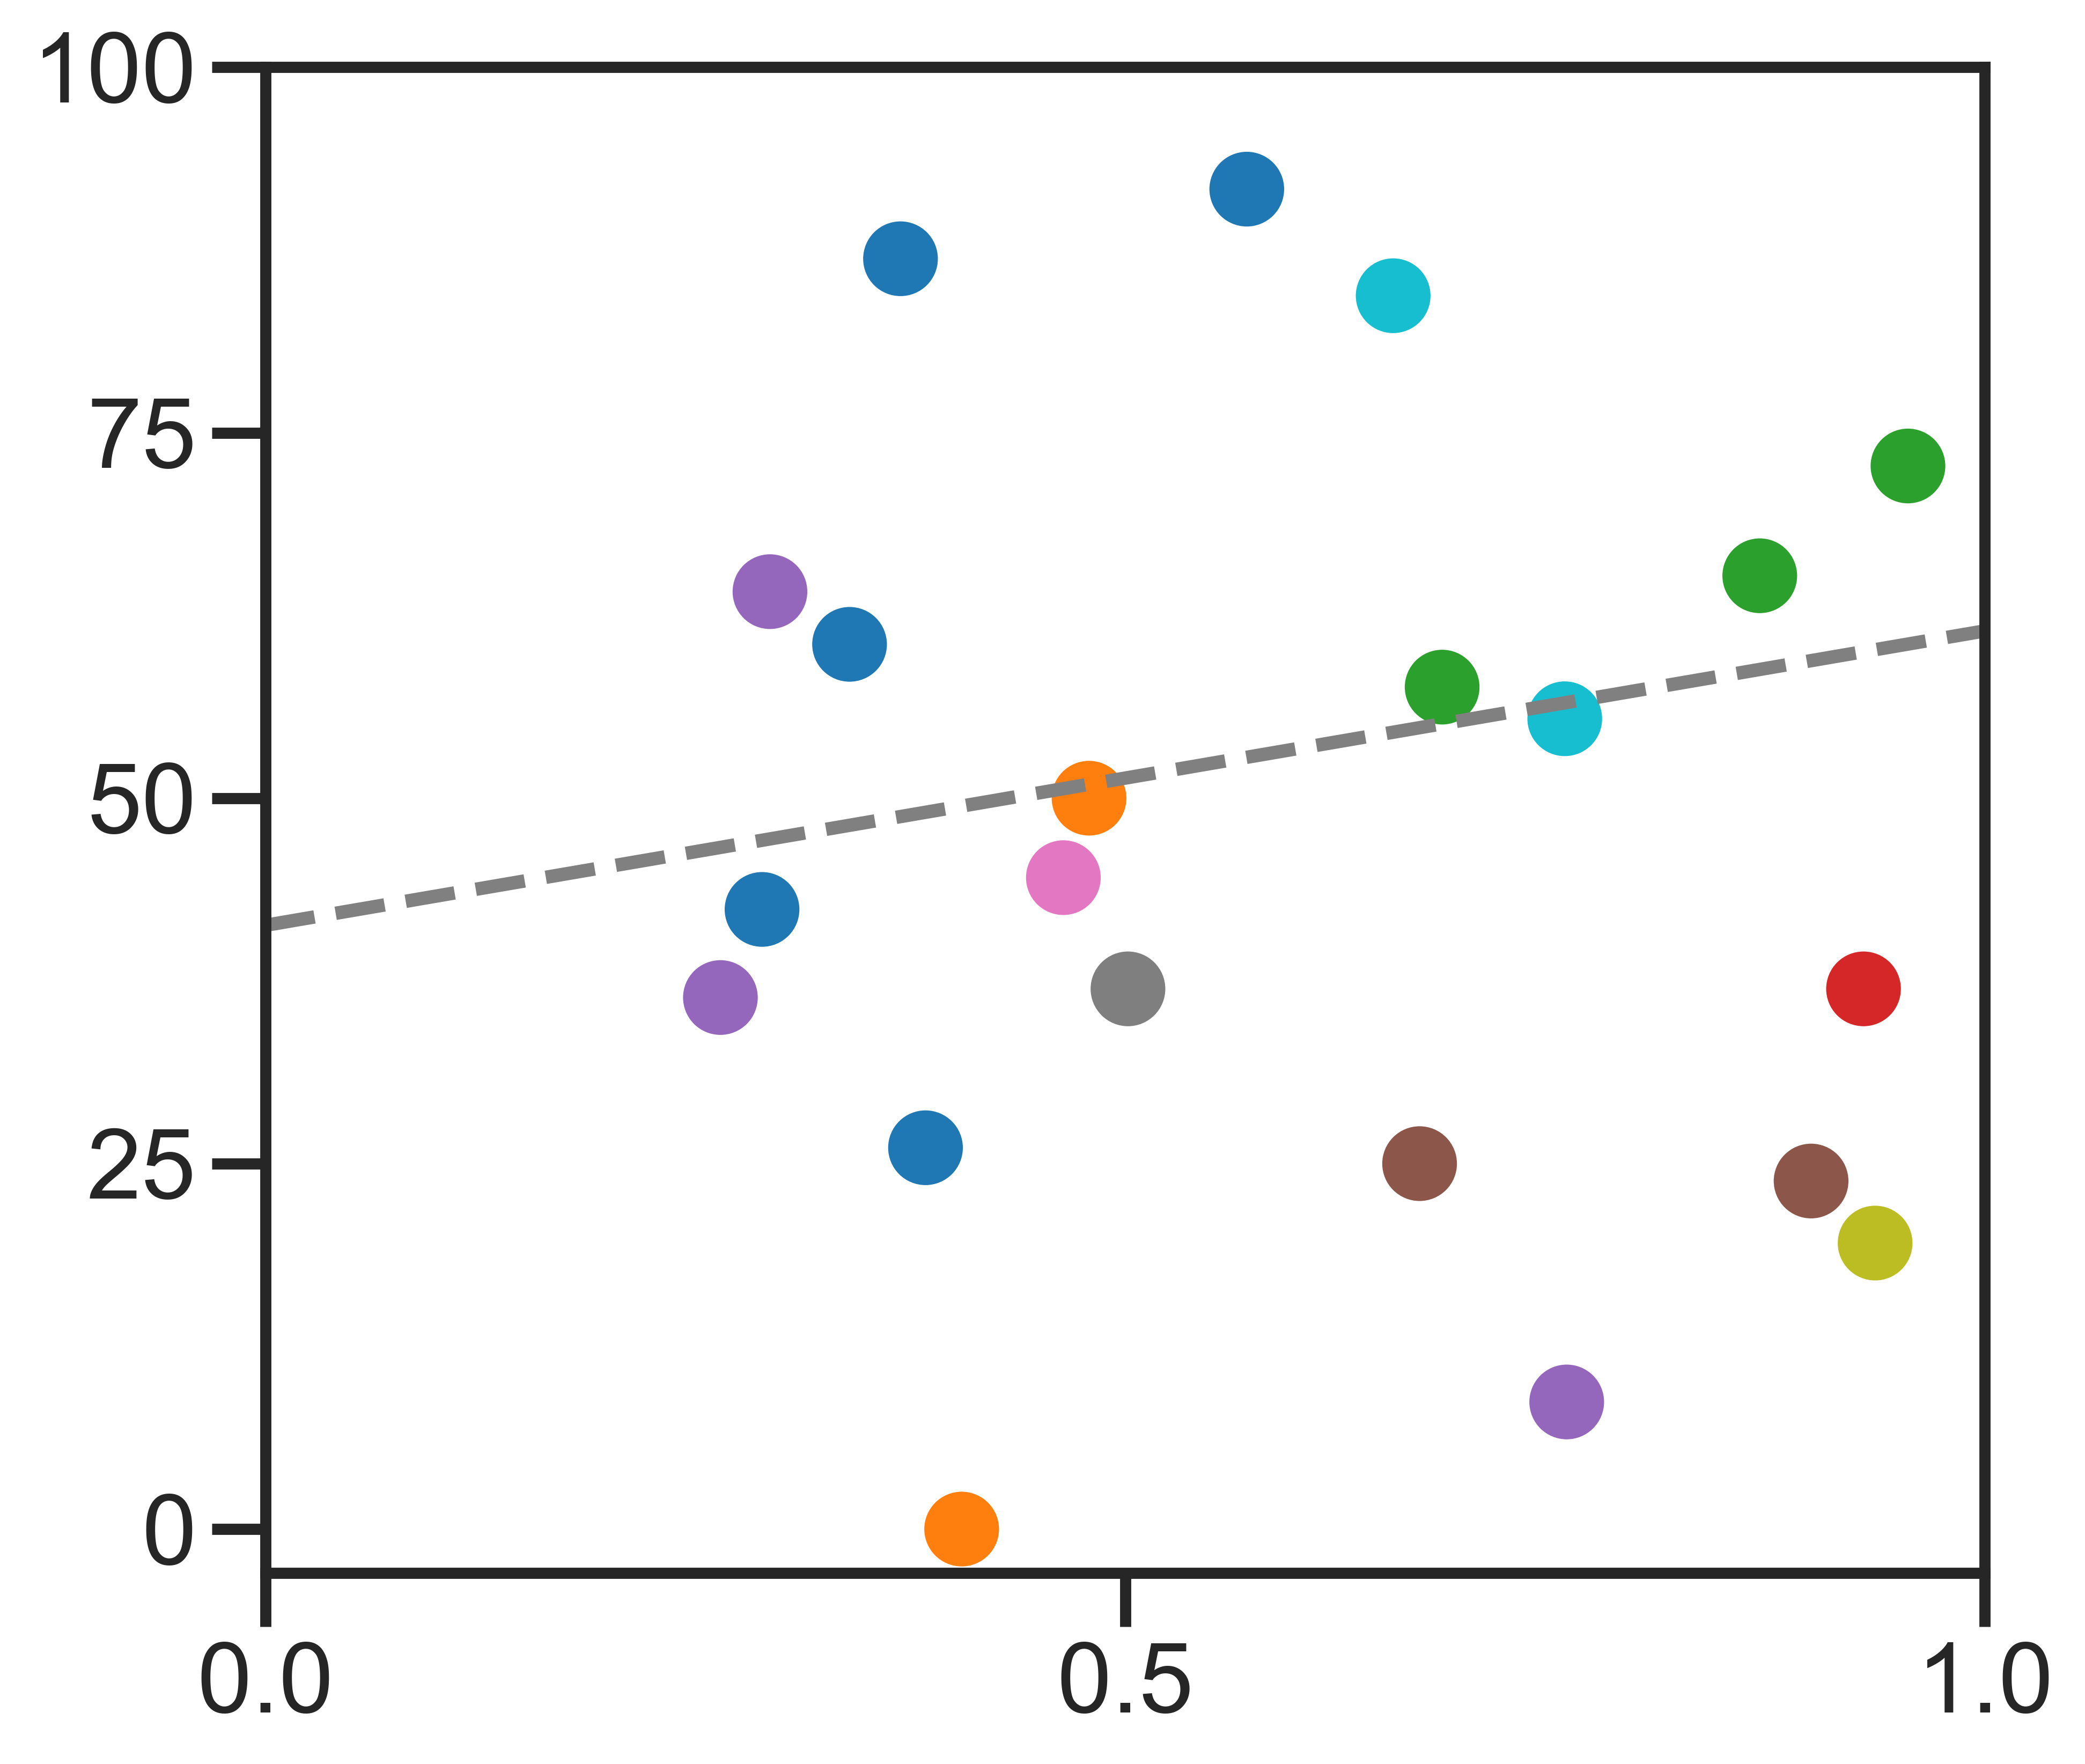

In [70]:
#PEDSQL VS ALPHA POWER + BEST FIT LINE
from pymer4.models import Lmer
from pymer4.stats import rsquared


# Fit the mixed-effects model
model = Lmer("total_score_pedsql ~ AlphaPower + AlphaPower*intervalType + (1|Patient)", 
             data=pedsql_data_df)
result = model.fit()
print(result)

# Extract coefficients for Intercept and BetaPower from the model summary
intercept = model.coefs['Estimate']['(Intercept)']
alpha_power_slope = model.coefs['Estimate']['AlphaPower']

# Extract the dependent variable (y), residuals (res), and calculate R-squared
y = pedsql_data_df['total_score_pedsql'].values  # Dependent variable as a 1D array
res = model.residuals  # Residuals as a 1D array
r2_values = rsquared(y, res)

# Calculate the predicted line of best fit
pedsql_data_df['BestFit_alpha'] = intercept + alpha_power_slope * pedsql_data_df['AlphaPower']

# Create the scatter plot
plt.figure(figsize=(7, 6))
sns.set_context('poster')
sns.set_style("ticks")

# Scatter plot of actual data
ax = sns.scatterplot(
    data=pedsql_data_df,
    x='AlphaPower',
    y='total_score_pedsql',
    hue='ID_in_Paper',  # Use IDs for legend
    palette='tab10',
    s=330,
    hue_order=['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']
)

# Line plot for the line of best fit
x_vals = np.linspace(0, 1, 100)  # BetaPower range
y_vals = intercept + alpha_power_slope * x_vals
plt.plot(x_vals, y_vals, color='grey', linestyle='--')

# Customize the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1)
plt.ylim(-3, 100)
plt.xticks(np.arange(0, 1.05, 0.5))
plt.yticks(np.arange(0, 105, 25))
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_72304/3875072790.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedsql_data_df['BestFit_alpha'] = intercept + theta_power_slope * pedsql_data_df['ThetaPower']


Linear mixed model fit by REML [’lmerMod’]
Formula: total_score_pedsql~ThetaPower+ThetaPower*intervalType+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 21	 Groups: {'Patient': 10.0}

Log-likelihood: -79.398 	 AIC: 170.795

Random effects:

                 Name      Var     Std
Patient   (Intercept)  224.730  14.991
Residual               434.238  20.838

No random effect correlations specified

Fixed effects:

                               Estimate   2.5_ci  97.5_ci      SE      DF  \
(Intercept)                      16.106  -55.189   87.400  36.375  16.946   
ThetaPower                       51.597  -55.359  158.553  54.570  16.935   
intervalTypestatus              -15.276  -96.717   66.165  41.552  13.799   
ThetaPower:intervalTypestatus     2.761 -122.383  127.905  63.850  14.462   

                               T-stat  P-val Sig  
(Intercept)                     0.443  0.664      
ThetaPower                      0.946  0.358      
intervalTypest

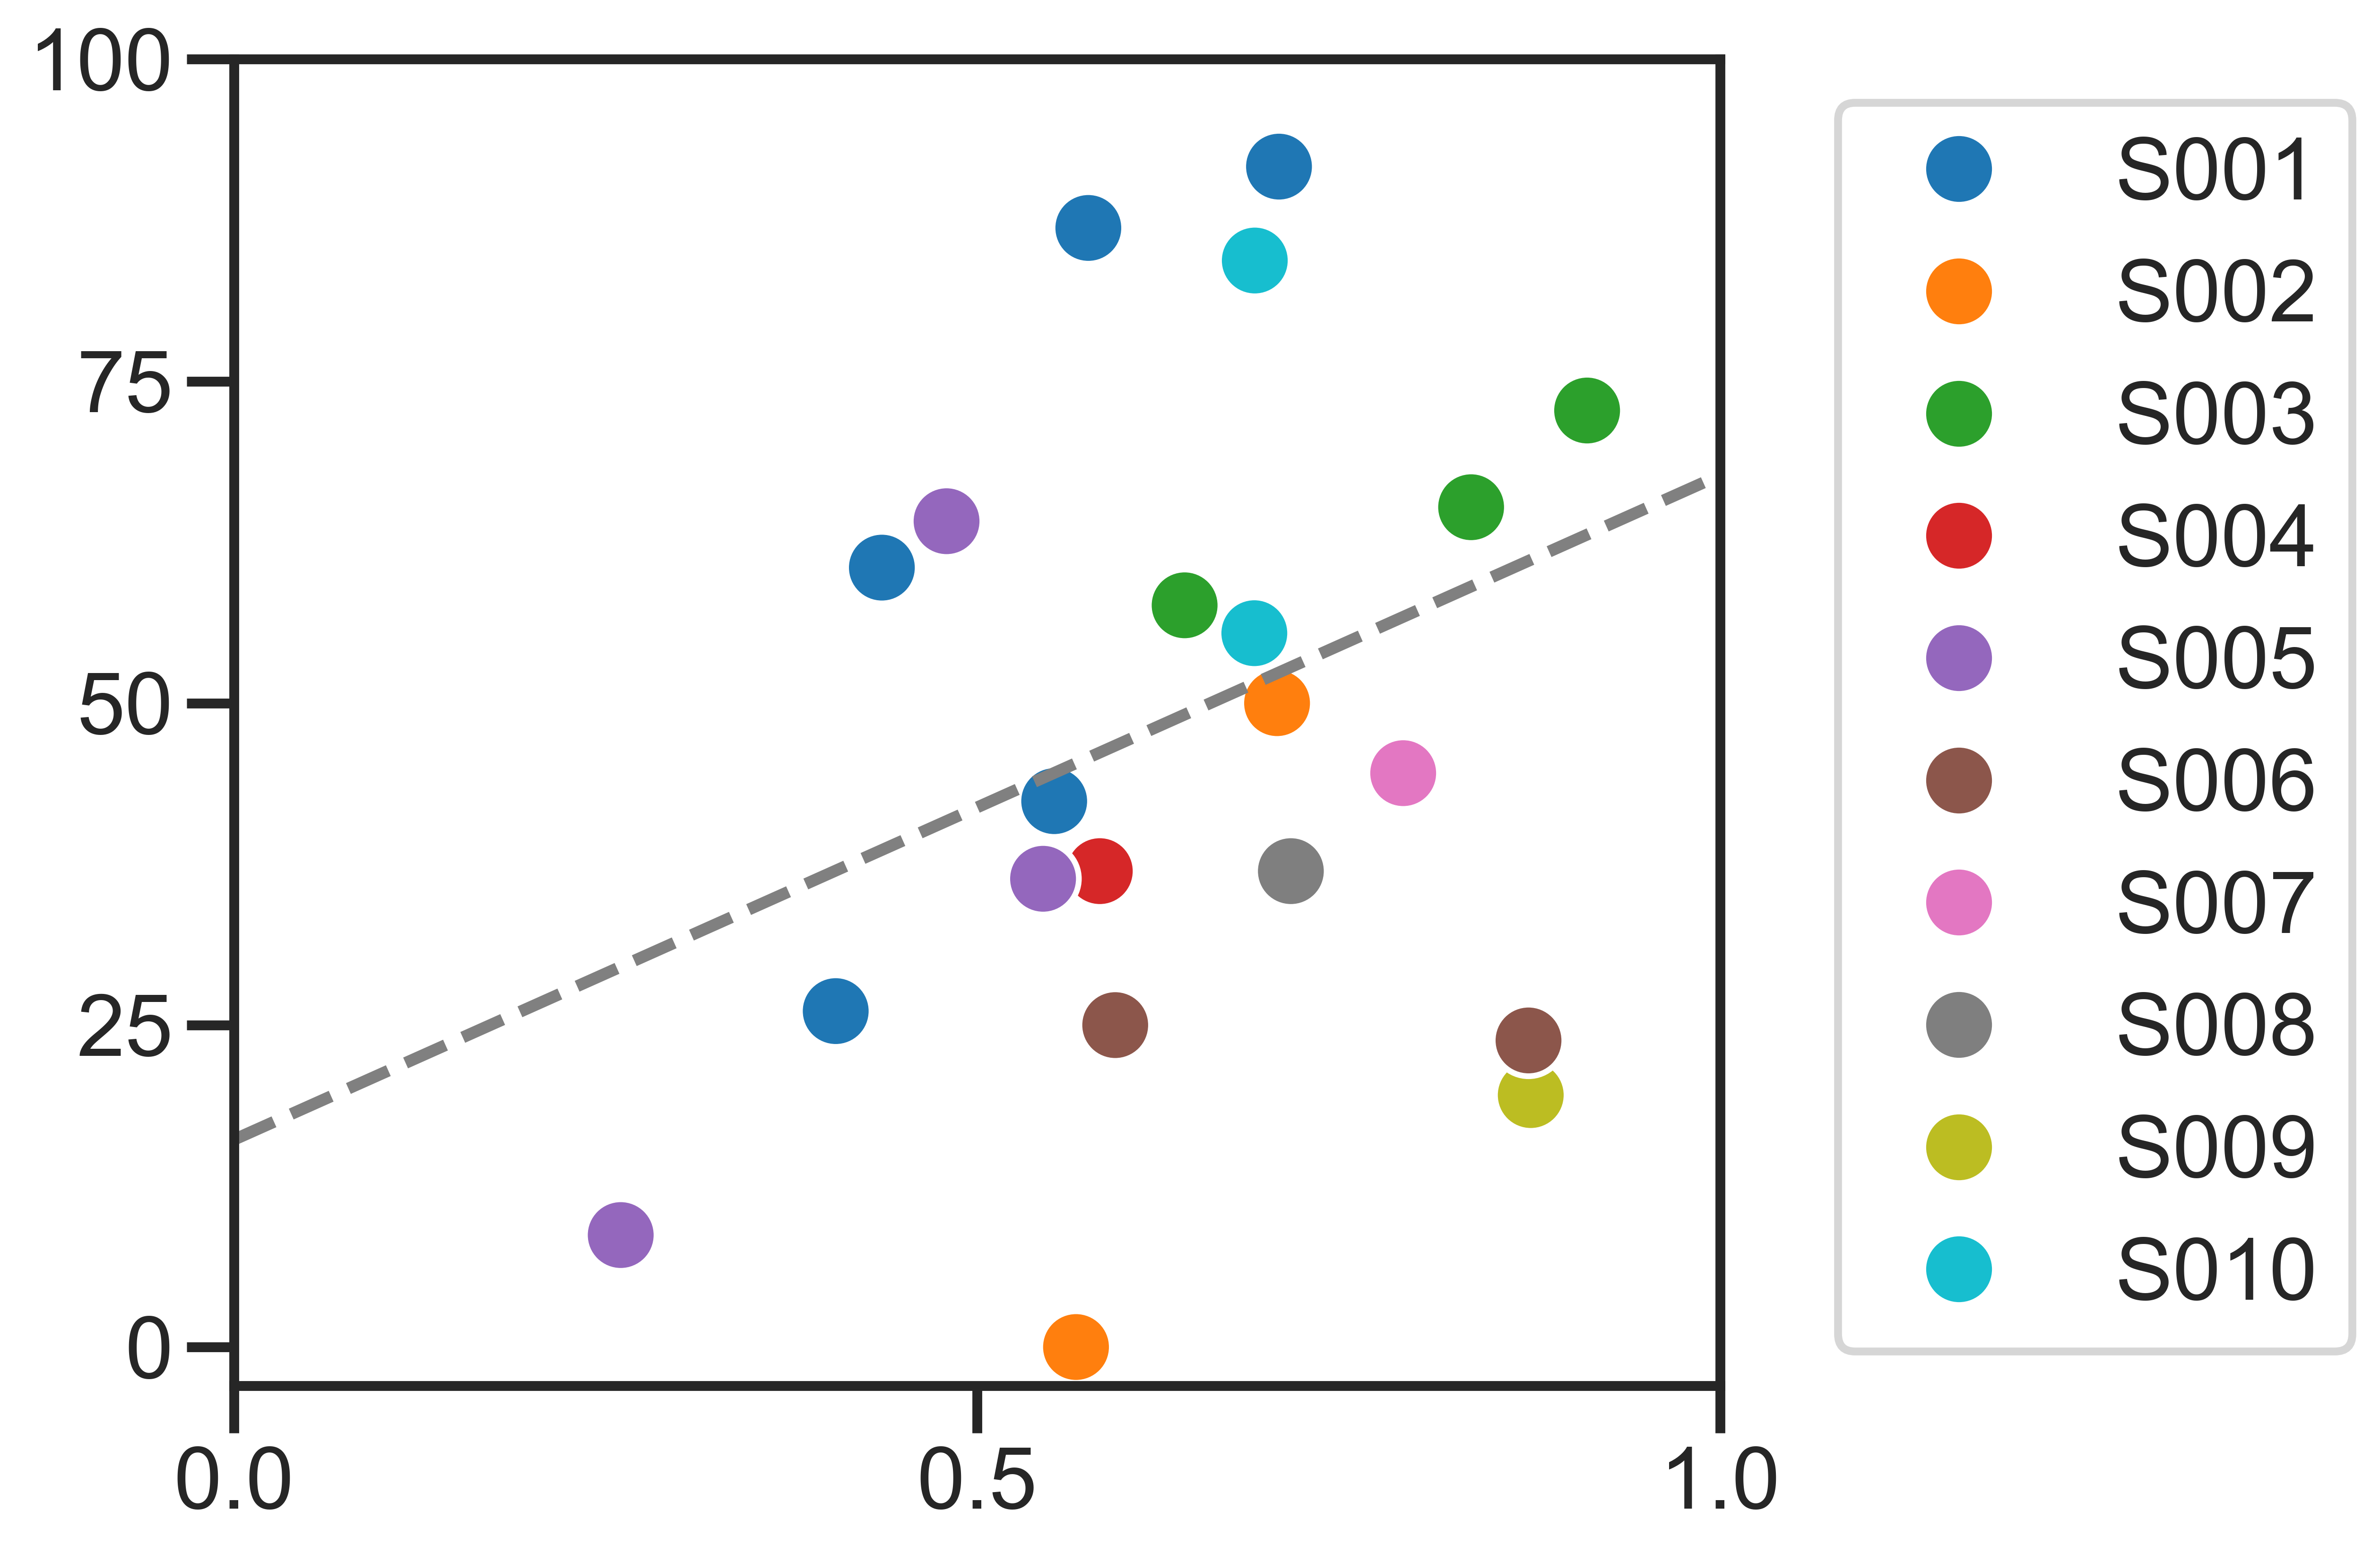

In [73]:
#PEDSQL VS THETA POWER + BEST FIT LINE
from pymer4.models import Lmer
from pymer4.stats import rsquared


# Fit the mixed-effects model
model = Lmer("total_score_pedsql ~ ThetaPower + ThetaPower*intervalType + (1|Patient)", 
             data=pedsql_data_df)
result = model.fit()
print(result)

# Extract coefficients for Intercept and BetaPower from the model summary
intercept = model.coefs['Estimate']['(Intercept)']
theta_power_slope = model.coefs['Estimate']['ThetaPower']

# Extract the dependent variable (y), residuals (res), and calculate R-squared
y = pedsql_data_df['total_score_pedsql'].values  # Dependent variable as a 1D array
res = model.residuals  # Residuals as a 1D array
r2_values = rsquared(y, res)

# Calculate the predicted line of best fit
pedsql_data_df['BestFit_alpha'] = intercept + theta_power_slope * pedsql_data_df['ThetaPower']

# Create the scatter plot
plt.figure(figsize=(9, 6))
sns.set_context('poster')
sns.set_style("ticks")

# Scatter plot of actual data
ax = sns.scatterplot(
    data=pedsql_data_df,
    x='ThetaPower',
    y='total_score_pedsql',
    hue='ID_in_Paper',  # Use IDs for legend
    palette='tab10',
    s=330,
    hue_order=['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']
)

# Line plot for the line of best fit
x_vals = np.linspace(0, 1, 100)  # BetaPower range
y_vals = intercept + theta_power_slope * x_vals
plt.plot(x_vals, y_vals, color='grey', linestyle='--')

# Customize the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1)
plt.ylim(-3, 100)
plt.xticks(np.arange(0, 1.05, 0.5))
plt.yticks(np.arange(0, 105, 25))
ax.set(xlabel=None)
ax.set(ylabel=None)
#ax.get_legend().remove()

plt.tight_layout()
plt.show()

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_72304/4024052704.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bfmdrs_data_df['ID_in_Paper'] = bfmdrs_data_df['Patient'].map(patient_id_mapping)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_72304/4024052704.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Linear mixed model fit by REML [’lmerMod’]
Formula: BFMDRS~BetaPower+BetaPower*intervalType+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 16	 Groups: {'Patient': 7.0}

Log-likelihood: -56.251 	 AIC: 124.502

Random effects:

                 Name      Var     Std
Patient   (Intercept)  575.485  23.989
Residual               376.260  19.397

No random effect correlations specified

Fixed effects:

                              Estimate   2.5_ci  97.5_ci       SE      DF  \
(Intercept)                     84.200    9.756  158.644   37.982  11.912   
BetaPower                      -49.363 -180.211   81.485   66.760  11.988   
intervalTypestatus              28.381 -116.573  173.335   73.957  11.710   
BetaPower:intervalTypestatus    11.625 -210.206  233.455  113.181  11.932   

                              T-stat  P-val Sig  
(Intercept)                    2.217  0.047   *  
BetaPower                     -0.739  0.474      
intervalTypestatus             0

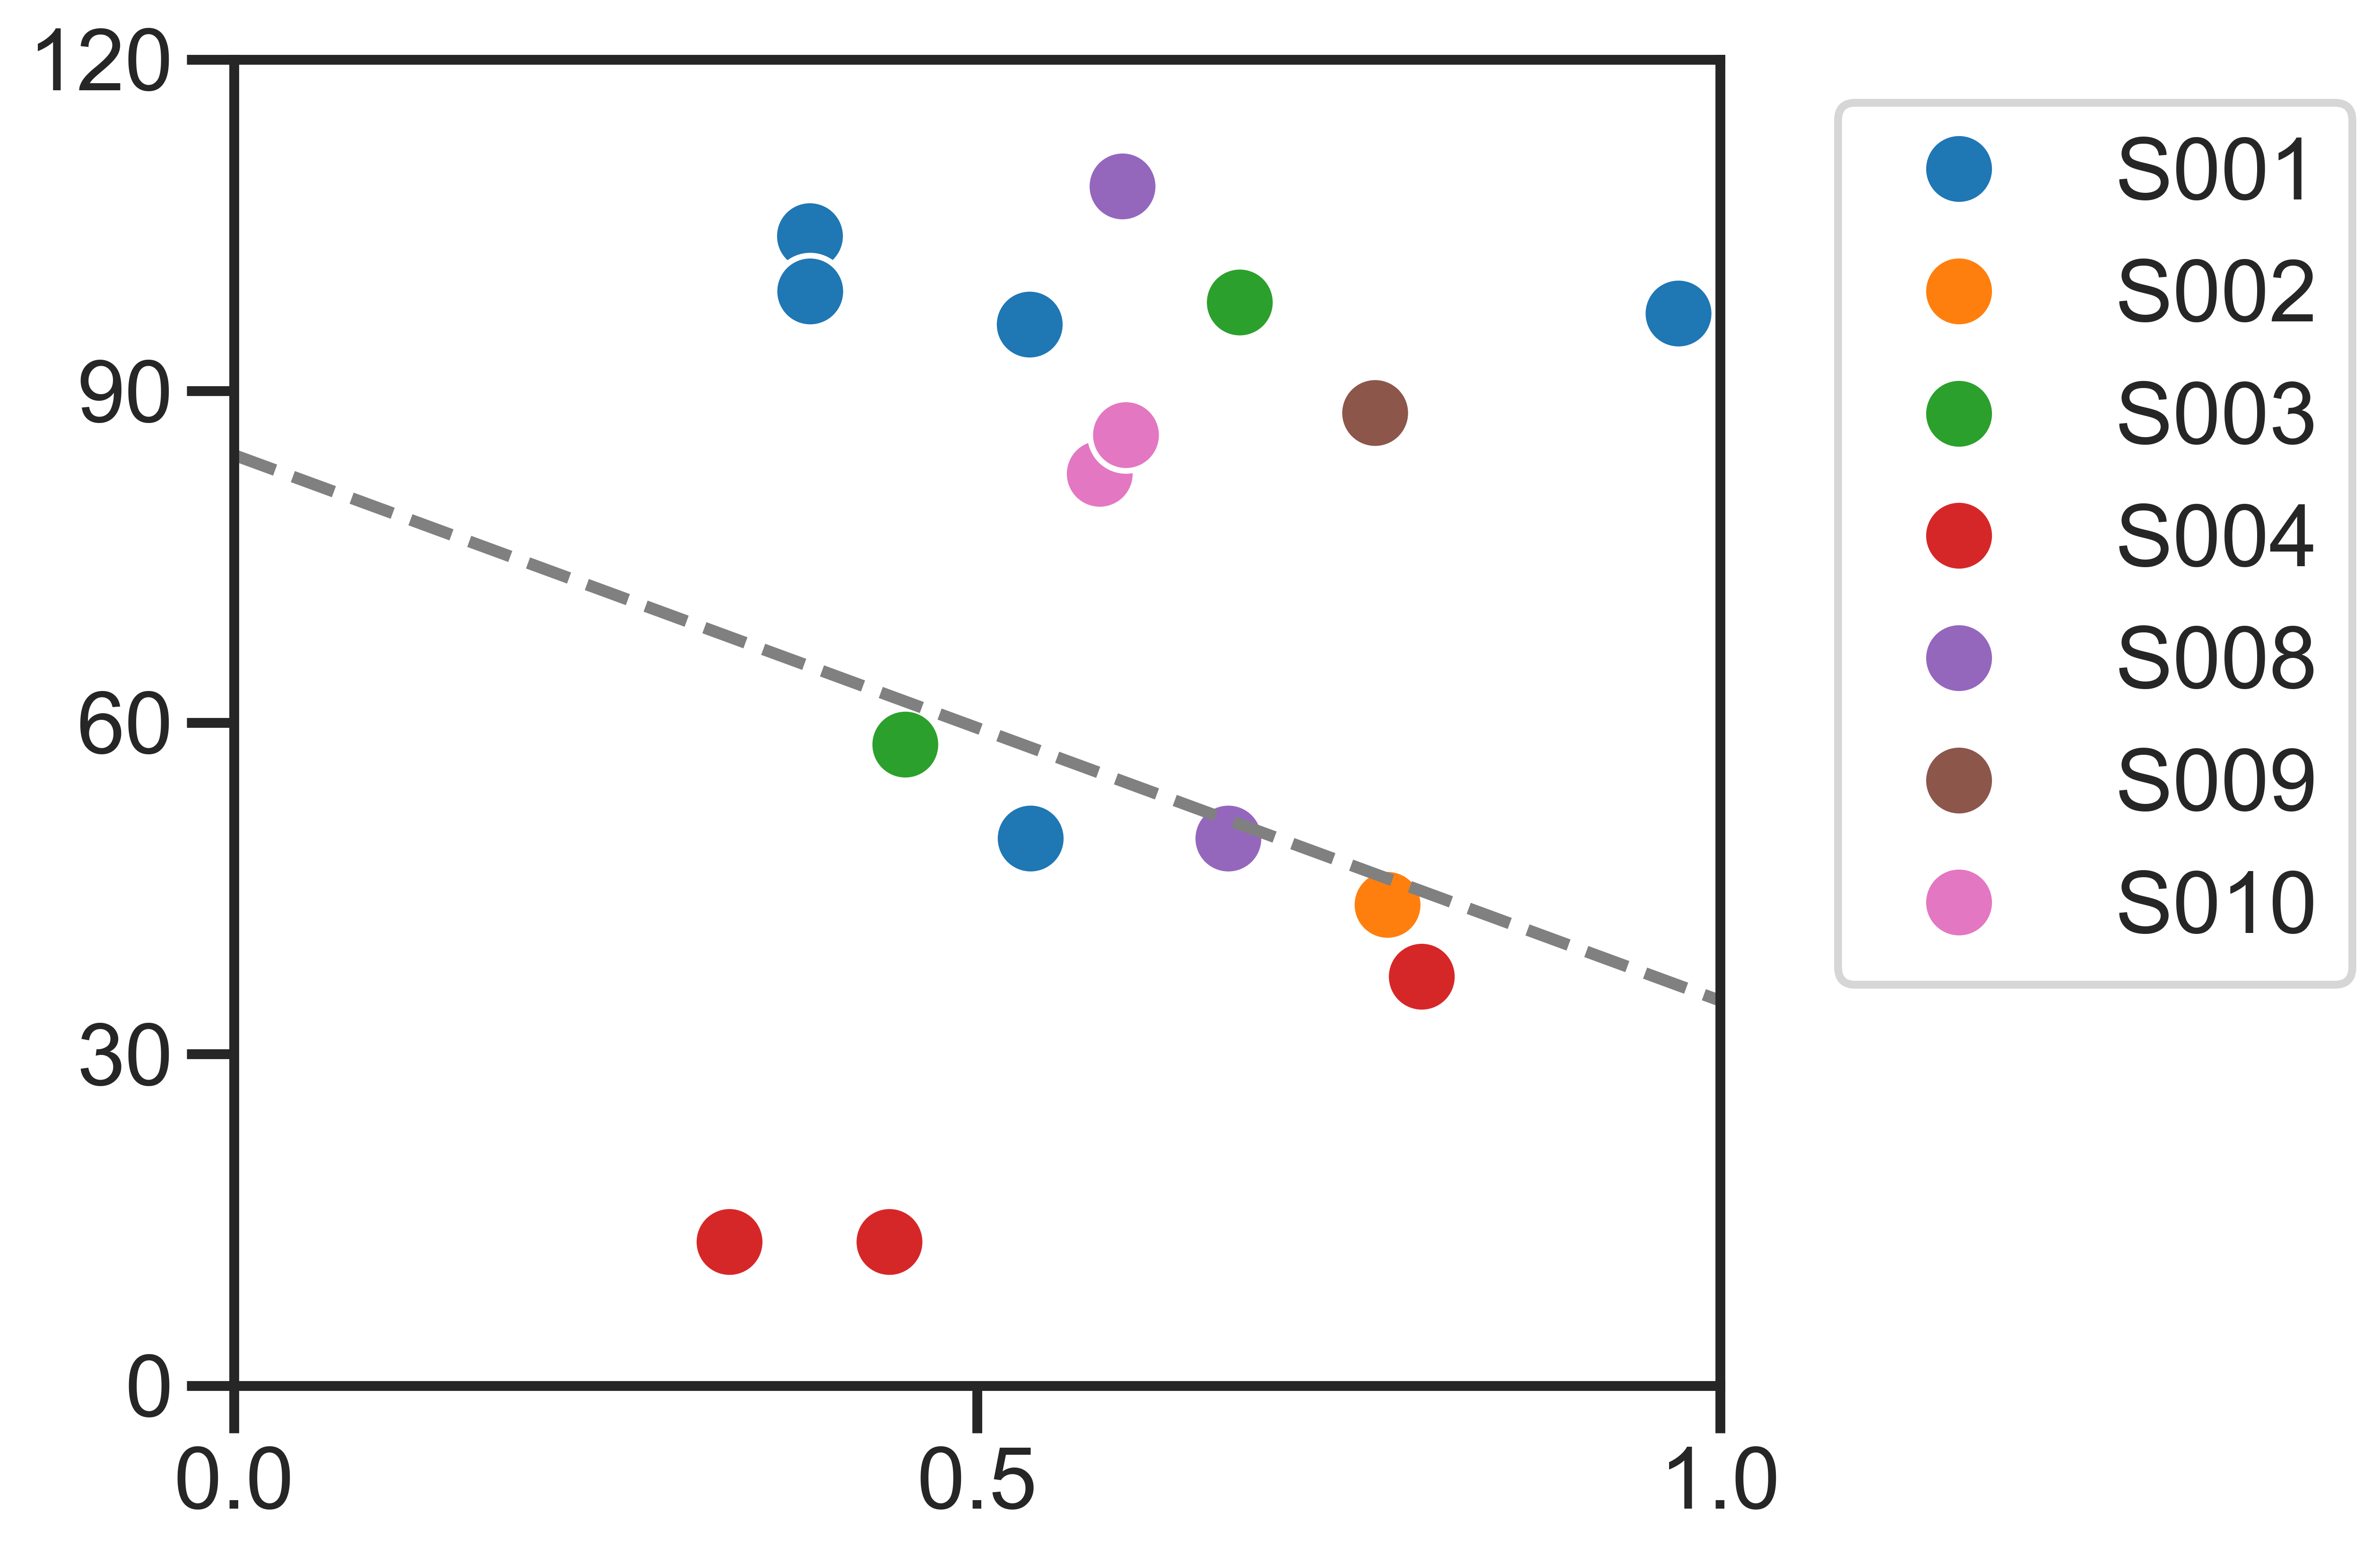

In [63]:
#PLOT BFMDRS vs Beta

bfmdrs_data_df = all_data_df.dropna(subset=['PeakPW', 'BFMDRS'])

# Define the mapping between Patient and ID in Paper
patient_id_mapping = {
    'DBS003': 'S001',
    'DBS005': 'S008',
    'DBS013': 'S002',
    'DBS014': 'S009',
    'DBS018': 'S010',
    'DBS021': 'S003',
    'DBS036': 'S004',
    'DBS039': 'S005',
    'DBS047': 'S006',
    'DBS050': 'S007'
}

# Replace the 'Patient' column values with the corresponding IDs in the mapping
bfmdrs_data_df['ID_in_Paper'] = bfmdrs_data_df['Patient'].map(patient_id_mapping)
# Define the desired order for the legend
id_order = ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']
# Filter `id_order` to include only IDs present in the dataset
filtered_id_order = [
    id_ for id_ in id_order if id_ in bfmdrs_data_df['ID_in_Paper'].unique()
]

# Fit the mixed-effects model for BFMDRS vs. Beta Power
model = Lmer("BFMDRS ~ BetaPower + BetaPower*intervalType + (1|Patient)", 
             data=bfmdrs_data_df)
result = model.fit()
print(result)

# Extract coefficients for Intercept and BetaPower from the model summary
intercept = model.coefs['Estimate']['(Intercept)']
beta_power_slope = model.coefs['Estimate']['BetaPower']

# Extract the dependent variable (y), residuals (res), and calculate R-squared
y = bfmdrs_data_df['BFMDRS'].values  # Dependent variable as a 1D array
res = model.residuals  # Residuals as a 1D array
r2_values = rsquared(y, res)

# Calculate the predicted line of best fit
bfmdrs_data_df['BestFit'] = intercept + beta_power_slope * bfmdrs_data_df['BetaPower']

# Create the scatter plot
plt.figure(figsize=(9, 6))
sns.set_context('poster')
sns.set_style("ticks")

# Scatter plot of actual data
ax = sns.scatterplot(
    data=bfmdrs_data_df,
    x='BetaPower',
    y='BFMDRS',
    hue='ID_in_Paper',
    palette='tab10',
    s=330,
    hue_order=filtered_id_order  # Use filtered legend order
)

# Line plot for the line of best fit
x_vals = np.linspace(0, 1, 100)  # BetaPower range
y_vals = intercept + beta_power_slope * x_vals
plt.plot(x_vals, y_vals, color='grey', linestyle='--')

# Customize the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1)
plt.ylim(bfmdrs_data_df['BFMDRS'].min() - 10, bfmdrs_data_df['BFMDRS'].max() + 10)
plt.xticks(np.arange(0, 1.05, 0.5))
plt.yticks(np.arange(0, 130, 30))

ax.set(xlabel=None)
ax.set(ylabel=None)
plt.tight_layout()
plt.show()
